# XGBoost (Dataset in_chemico)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import rdMolDescriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna

## Molecule, Descriptor and Outlier Functions

In [14]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_fingerprints(molecule, fingerprint_bits=256, radius=2, maccs_bits=None):
    # If molecule is invalid - return NaNs for alignment
    if molecule is None:
        if maccs_bits is None:
            # Get default MACCS length from a dummy molecule
            maccs_bits = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles("CC")).GetNumBits()

        morgan_arr = np.full(fingerprint_bits, np.nan)
        atompair_arr = np.full(fingerprint_bits, np.nan)
        torsion_arr = np.full(fingerprint_bits, np.nan)
        rdk_arr = np.full(fingerprint_bits, np.nan)
        maccs_arr = np.full(maccs_bits, np.nan)
        return morgan_arr, atompair_arr, torsion_arr, rdk_arr, maccs_arr

    # Reduce logs
    RDLogger.DisableLog('rdApp.*')

    # Morgan FP
    fp_morgan = AllChem.GetMorganFingerprintAsBitVect(
        molecule, radius=radius, nBits=fingerprint_bits
    )
    morgan_arr = np.zeros((fingerprint_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp_morgan, morgan_arr)

    # AtomPair FP
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
        molecule, nBits=fingerprint_bits
    )
    atompair_arr = np.zeros((fingerprint_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp_ap, atompair_arr)

    # Topological torsion FP
    fp_torsion = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(
        molecule, nBits=fingerprint_bits
    )
    torsion_arr = np.zeros((fingerprint_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp_torsion, torsion_arr)

    # RDKit topological FP
    fp_rdk = Chem.RDKFingerprint(molecule, fpSize=fingerprint_bits)
    rdk_arr = np.zeros((fingerprint_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp_rdk, rdk_arr)

    # MACCS keys
    fp_maccs = MACCSkeys.GenMACCSKeys(molecule)
    if maccs_bits is None:
        maccs_bits = fp_maccs.GetNumBits()
    maccs_arr = np.zeros((maccs_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp_maccs, maccs_arr)

    RDLogger.EnableLog('rdApp.*')

    return morgan_arr, atompair_arr, torsion_arr, rdk_arr, maccs_arr


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

## Dataset Processing

In [15]:
CHEMDES_COL = [
    # quantum
    "HOMO_eV", "LUMO_eV", "HL_Gap_eV", "Pol",
    # Q* charge descriptors
    "Qass", "QCmax", "QCmin", "QCss",
    "QHmax", "QHmin", "QHss",
    "Qmax", "Qmin",
    "QNmax", "QNmin", "QNss",
    "QOmax", "QOmin", "QOss",
    # Chi/Chiv charge-weighted
    "Chi3ch", "Chi4ch", "Chi4pc", "Chi5ch", "Chi6ch",
    "Chiv3ch", "Chiv4ch", "Chiv4pc", "Chiv5ch", "Chiv6ch",
    # ATS (v/e/p)
    "ATSe1","ATSe2","ATSe3","ATSe4","ATSe5","ATSe6","ATSe7","ATSe8",
    "ATSp1","ATSp2","ATSp3","ATSp4","ATSp5","ATSp6","ATSp7","ATSp8",
    "ATSv1","ATSv2","ATSv3","ATSv4","ATSv5","ATSv6","ATSv7","ATSv8",
    # MATS (v/e/p)
    "MATSe1","MATSe2","MATSe3","MATSe4","MATSe5","MATSe6","MATSe7","MATSe8",
    "MATSv1","MATSv2","MATSv3","MATSv4","MATSv5","MATSv6","MATSv7","MATSv8",
    "MATSp1","MATSp2","MATSp3","MATSp4","MATSp5","MATSp6","MATSp7","MATSp8",
    # GATS (v/e/p)
    "GATSe1","GATSe2","GATSe3","GATSe4","GATSe5","GATSe6","GATSe7","GATSe8",
    "GATSv1","GATSv2","GATSv3","GATSv4","GATSv5","GATSv6","GATSv7","GATSv8",
    "GATSp1","GATSp2","GATSp3","GATSp4","GATSp5","GATSp6","GATSp7","GATSp8",
]

ORIG_DATASET = "datasets/in_chemico.csv"
SKIP_ROWS = 0
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"

FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

TRAIN_X_CSV = "x_train.csv"
TEST_X_CSV = "x_test.csv"
TRAIN_Y_CSV = "y_train.csv"
TEST_Y_CSV = "y_test.csv"

SIMILARITY_THRESHOLD = 0.90
CORRELATION_THRESHOLD = 0.95

FINGERPRINT_BITS = 512
FINGERPRINT_RADIUS = 2

MORGAN_PREFIX = "Morgan_"
ATOMPAIR_PREFIX = "AtomPair_"
TORSION_PREFIX = "Torsion_"
RDK_PREFIX = "RDK_"
MACCS_PREFIX = "MACCS_"

FINGERPRINT_PREFIXES = [
    MORGAN_PREFIX,
    ATOMPAIR_PREFIX,
    TORSION_PREFIX,
    RDK_PREFIX,
    MACCS_PREFIX,
]

MACCS_BITS = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles("CC")).GetNumBits()

# Load dataset
dataset = pd.read_csv(ORIG_DATASET, skiprows=SKIP_ROWS)

print("Columns check: SMILES =", SMILES_COL in dataset.columns,
      ", Target =", TARGET_COL in dataset.columns)

missing_desc = [c for c in CHEMDES_COL if c not in dataset.columns]
if missing_desc:
    raise ValueError(f"These requested descriptors are missing from dataset: {missing_desc}")

# Build RDKit descriptors + fingerprints
descriptor_rows = []
state_molecules = []
molecules = []

morgan_rows = []
atompair_rows = []
torsion_rows = []
rdk_rows = []
maccs_rows = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # RDKit descriptors
    if molecule is None:
        descriptor_rows.append({})
    else:
        descriptor_rows.append(calculate_descriptors(molecule))

    # Fingerprints
    morgan_arr, atompair_arr, torsion_arr, rdk_arr, maccs_arr = compute_fingerprints(molecule, fingerprint_bits=FINGERPRINT_BITS, 
        radius=FINGERPRINT_RADIUS, maccs_bits=MACCS_BITS,)

    morgan_rows.append(morgan_arr)
    atompair_rows.append(atompair_arr)
    torsion_rows.append(torsion_arr)
    rdk_rows.append(rdk_arr)
    maccs_rows.append(maccs_arr)

# RDKit descriptor DataFrame
descriptor_data_rdkit = pd.DataFrame(descriptor_rows)

# Chemdes subset
descriptor_data_chemdes = dataset[CHEMDES_COL].reset_index(drop=True)

# Combine RDKit + Chemdes descriptors
descriptor_data_all = pd.concat(
    [descriptor_data_chemdes.reset_index(drop=True),
     descriptor_data_rdkit.reset_index(drop=True),
     ],
    axis=1
)

# Fingerprints DataFrame
fp_morgan_cols = [f"{MORGAN_PREFIX}{i}" for i in range(FINGERPRINT_BITS)]
fp_atompair_cols = [f"{ATOMPAIR_PREFIX}{i}" for i in range(FINGERPRINT_BITS)]
fp_torsion_cols = [f"{TORSION_PREFIX}{i}" for i in range(FINGERPRINT_BITS)]
fp_rdk_cols = [f"{RDK_PREFIX}{i}" for i in range(FINGERPRINT_BITS)]
fp_maccs_cols = [f"{MACCS_PREFIX}{i}" for i in range(MACCS_BITS)]

fingerprint_data_all = pd.concat(
    [
        pd.DataFrame(morgan_rows, columns=fp_morgan_cols),
        pd.DataFrame(atompair_rows, columns=fp_atompair_cols),
        pd.DataFrame(torsion_rows, columns=fp_torsion_cols),
        pd.DataFrame(rdk_rows, columns=fp_rdk_cols),
        pd.DataFrame(maccs_rows, columns=fp_maccs_cols),
    ],
    axis=1,
)

# Save whole dataset for inspection
output = pd.concat(
    [
        descriptor_data_all.reset_index(drop=True),
    ],
    axis=1,
)
output["MoleculeStatus"] = state_molecules
output[SMILES_COL] = dataset[SMILES_COL]
output[TARGET_COL] = dataset[TARGET_COL]

with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Filter to valid molecules only
molecules_right = [m is not None for m in molecules]
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

print("Molecule status counts:")
print(pd.Series(state_molecules).value_counts())
print()

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)
fingerprint_ok = fingerprint_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Numeric descriptors
X_desc_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_desc_full.columns:
    X_desc_full[column] = X_desc_full[column].replace([np.inf, -np.inf], np.nan)

# Fingerprints
X_fp_full = fingerprint_ok.copy()
X_fp_full = X_fp_full.fillna(0).astype(int)

# Combine descriptors + fingerprints
X_full = pd.concat([X_desc_full, X_fp_full], axis=1)

# Drop all-NaN columns
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)


# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Identify descriptor and fingerprint columns
fingerprint_cols = [
    c for c in X_train.columns
    if any(c.startswith(pref) for pref in FINGERPRINT_PREFIXES)
]
descriptor_cols = [c for c in X_train.columns if c not in fingerprint_cols]

print(f"Descriptor columns: {len(descriptor_cols)}")
print(f"Fingerprint columns: {len(fingerprint_cols)}")
print()

# Missing values (Descriptors only)
train_medians = X_train[descriptor_cols].median()
X_train[descriptor_cols] = X_train[descriptor_cols].fillna(train_medians)
X_test[descriptor_cols] = X_test[descriptor_cols].fillna(train_medians)

# Drop constant / near-constant columns
constant_cols = []
for col in X_train.columns:
    value_counts = X_train[col].value_counts(normalize=True, dropna=False)

    if col in fingerprint_cols:
        # Drop only truly constant bits
        if len(value_counts) == 1:
            constant_cols.append(col)
    else:
        top_freq = value_counts.max()
        if top_freq >= SIMILARITY_THRESHOLD:
            constant_cols.append(col)

if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant columns.")

    fingerprint_cols = [
        c for c in X_train.columns
        if any(c.startswith(pref) for pref in FINGERPRINT_PREFIXES)
    ]
    descriptor_cols = [c for c in X_train.columns if c not in fingerprint_cols]

# Correlation filter (Descriptors only)
if descriptor_cols:
    corr_matrix = X_train[descriptor_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [
        col for col in upper.columns if any(upper[col] > CORRELATION_THRESHOLD)
    ]
else:
    high_corr_cols = []

if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated descriptor columns.")

    fingerprint_cols = [
        c for c in X_train.columns
        if any(c.startswith(pref) for pref in FINGERPRINT_PREFIXES)
    ]
    descriptor_cols = [c for c in X_train.columns if c not in fingerprint_cols]

# IQR clipping (Descriptors only)
if descriptor_cols:
    iqr_limits = compute_iqr_limits(X_train[descriptor_cols], factor=1.5)
    X_train_desc_clipped = apply_iqr_limits(X_train[descriptor_cols], iqr_limits)
    X_test_desc_clipped = apply_iqr_limits(X_test[descriptor_cols], iqr_limits)
    X_train[descriptor_cols] = X_train_desc_clipped
    X_test[descriptor_cols] = X_test_desc_clipped

# Save processed train/test
X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"\nTrain - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Columns check: SMILES = True , Target = True
Full - Rows: 162/Columns: 321
 HOMO_eV  LUMO_eV  HL_Gap_eV  Pol  Qass  QCmax  QCmin  QCss  QHmax  QHmin  QHss  Qmax   Qmin  QNmax  QNmin  QNss  QOmax  QOmin  QOss  Chi3ch  Chi4ch  Chi4pc  Chi5ch  Chi6ch  Chiv3ch  Chiv4ch  Chiv4pc  Chiv5ch  Chiv6ch  ATSe1  ATSe2  ATSe3  ATSe4  ATSe5  ATSe6  ATSe7  ATSe8  ATSp1  ATSp2  ATSp3  ATSp4  ATSp5  ATSp6  ATSp7  ATSp8  ATSv1  ATSv2  ATSv3  ATSv4  ATSv5  ATSv6  ATSv7  ATSv8  MATSe1  MATSe2  MATSe3  MATSe4  MATSe5  MATSe6  MATSe7  MATSe8  MATSv1  MATSv2  MATSv3  MATSv4  MATSv5  MATSv6  MATSv7  MATSv8  MATSp1  MATSp2  MATSp3  MATSp4  MATSp5  MATSp6  MATSp7  MATSp8  GATSe1  GATSe2  GATSe3  GATSe4  GATSe5  GATSe6  GATSe7  GATSe8  GATSv1  GATSv2  GATSv3  GATSv4  GATSv5  GATSv6  GATSv7  GATSv8  GATSp1  GATSp2  GATSp3  GATSp4  GATSp5  GATSp6  GATSp7  GATSp8  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadic

## Base Model Train

In [16]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42
)
# Train
base_model.fit(X_train[descriptor_cols], y_train)

# Predict
y_pred = base_model.predict(X_test[descriptor_cols])
y_prob = base_model.predict_proba(X_test[descriptor_cols])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.6741

Classification report:
              precision    recall  f1-score   support

           0      0.562     0.600     0.581        15
           1      0.647     0.611     0.629        18

    accuracy                          0.606        33
   macro avg      0.605     0.606     0.605        33
weighted avg      0.609     0.606     0.607        33



## Feature Selection

In [17]:
# Use only descriptor columns for all feature-selection stuff
X_train_desc = X_train[descriptor_cols].copy()
X_test_desc  = X_test[descriptor_cols].copy()

# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train_desc)
shap_result = explainer(X_train_desc, max_evals=2 * X_train_desc.shape[1] + 20)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=descriptor_cols).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=descriptor_cols)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - MI
kbest_mi = SelectKBest(score_func=mutual_info_classif, k='all')
kbest_mi.fit(X_train_desc, y_train)
kbest_mi_scores = pd.Series(kbest_mi.scores_, index=descriptor_cols).fillna(0.0)
kbest_features = kbest_mi_scores.sort_values(ascending=False)

# Lasso features
scaler = StandardScaler()
X_train_desc_scaled = scaler.fit_transform(X_train_desc)
X_test_desc_scaled  = scaler.transform(X_test_desc)

lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train_desc_scaled, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=descriptor_cols)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train_desc)

PermutationExplainer explainer: 130it [00:17,  4.51it/s]                         
/tmp/ipykernel_325572/517779684.py:46: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_desc)


In [18]:
shap_features.head(20)

PEOE_VSA8      0.068064
LUMO_eV        0.060617
EState_VSA7    0.056690
Chi6ch         0.052642
GATSv5         0.036080
AvgIpc         0.033986
SMR_VSA10      0.032036
MATSe2         0.029613
VSA_EState5    0.022294
VSA_EState4    0.020829
MATSe1         0.020181
HOMO_eV        0.018685
ATSe1          0.017270
GATSp3         0.015917
MATSv5         0.015366
SMR_VSA3       0.014736
QNmax          0.014120
GATSe3         0.014023
GATSv2         0.013424
Chiv6ch        0.012940
dtype: float64

In [19]:
xgb_features.head(20)

PEOE_VSA8                  0.072004
NumAromaticHeterocycles    0.049211
MATSv5                     0.047668
VSA_EState7                0.045101
Qmin                       0.042072
Chi6ch                     0.036608
MATSv2                     0.035997
MaxAbsEStateIndex          0.035686
fr_Ar_N                    0.030243
EState_VSA2                0.026277
BCUT2D_MRHI                0.025448
GATSp3                     0.024647
Chiv6ch                    0.023326
MATSv3                     0.022075
MATSe1                     0.021329
GATSp1                     0.021106
BalabanJ                   0.016632
MinAbsEStateIndex          0.016574
BCUT2D_LOGPLOW             0.013359
SlogP_VSA2                 0.013169
dtype: float32

In [20]:
kbest_features.head(20)

Chi6ch               0.185788
MaxAbsEStateIndex    0.177724
LUMO_eV              0.172482
RingCount            0.158239
SlogP_VSA4           0.154775
SlogP_VSA8           0.154774
PEOE_VSA8            0.149197
SMR_VSA7             0.149105
HL_Gap_eV            0.145447
ATSe7                0.144100
SMR_VSA3             0.141429
SlogP_VSA6           0.140252
MinAbsEStateIndex    0.135472
Qmin                 0.135093
QNmin                0.134803
NumAromaticRings     0.134658
MATSe2               0.130587
QNss                 0.128033
VSA_EState2          0.127554
GATSv1               0.119036
dtype: float64

In [21]:
lasso_features.head(20)

EState_VSA4          1.249640
SlogP_VSA10          1.116876
VSA_EState9          1.015313
EState_VSA5          0.961658
MinAbsEStateIndex    0.833390
GATSe4               0.813052
SlogP_VSA6           0.769068
PEOE_VSA3            0.676642
fr_Ndealkylation1    0.656379
LUMO_eV              0.638926
BCUT2D_MRLOW         0.622905
BCUT2D_LOGPHI        0.562682
SMR_VSA4             0.556455
MATSp7               0.529816
MATSe5               0.505578
VSA_EState5          0.461394
QNmax                0.430354
MATSe7               0.426105
BalabanJ             0.368442
MaxAbsEStateIndex    0.368006
dtype: float64

In [22]:
# Prepare fingerprints
morgan_cols = [c for c in X_train.columns if c.startswith(MORGAN_PREFIX)]
atompair_cols = [c for c in X_train.columns if c.startswith(ATOMPAIR_PREFIX)]
torsion_cols = [c for c in X_train.columns if c.startswith(TORSION_PREFIX)]
rdk_cols = [c for c in X_train.columns if c.startswith(RDK_PREFIX)]
maccs_cols = [c for c in X_train.columns if c.startswith(MACCS_PREFIX)]

## Model SHAP Features Tuning (Optuna CV)


=== Optuna: top 4 features ===


  AUC=0.669 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.619 | ACC=0.545

=== Optuna: top 8 features ===
  AUC=0.656 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.689 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.678 | ACC=0.636

=== Optuna: top 14 features ===
  AUC=0.678 | ACC=0.636

=== Optuna: top 16 features ===
  AUC=0.707 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.693 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.711 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.693 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.681 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.652 | ACC=0.667

=== Optuna: top 28 features ===
  AUC=0.689 | ACC=0.636

=== Optuna: top 30 features ===
  AUC=0.737 | ACC=0.727

=== Optuna: top 32 features ===
  AUC=0.685 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.674 | ACC=0.667

=== Optuna: top 36 features ===
  AUC=0.656 | ACC=0.606

=== Optuna: top 38 features ===
  AUC=0.707 | ACC=0.606

=== Optu

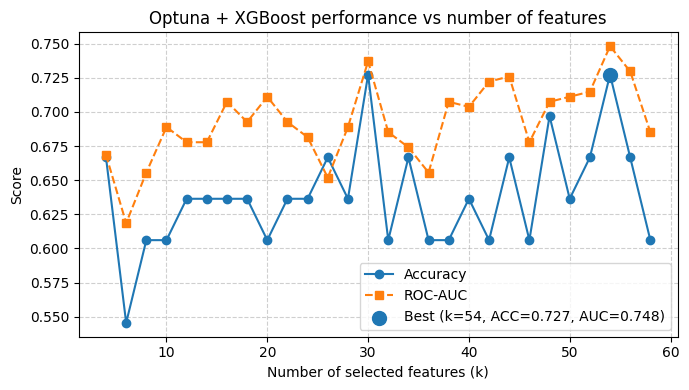

In [23]:
# Descriptors
ranking = shap_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Descriptors + Morgan
ranking = shap_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.644 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.667 | ACC=0.667

=== Optuna: top 8 features ===
  AUC=0.630 | ACC=0.545

=== Optuna: top 10 features ===
  AUC=0.722 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.748 | ACC=0.697

=== Optuna: top 14 features ===
  AUC=0.667 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.670 | ACC=0.545

=== Optuna: top 18 features ===
  AUC=0.678 | ACC=0.606

=== Optuna: top 20 features ===
  AUC=0.704 | ACC=0.636

=== Optuna: top 22 features ===
  AUC=0.696 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.652 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.707 | ACC=0.727

=== Optuna: top 28 features ===
  AUC=0.641 | ACC=0.545

=== Optuna: top 30 features ===
  AUC=0.700 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.648 | ACC=0.576

=== Optuna: top 34 features ===
  AUC=0.689 | ACC=0.667

=== Optuna: top 36 features ===
  AUC=0.663 | ACC=0.636

=== Optuna: top 38 features ===
 

In [25]:
# Descriptors + AtomPair
ranking = shap_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.726 | ACC=0.576

=== Optuna: top 6 features ===
  AUC=0.678 | ACC=0.545

=== Optuna: top 8 features ===
  AUC=0.689 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.678 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.700 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.741 | ACC=0.697

=== Optuna: top 16 features ===
  AUC=0.696 | ACC=0.576

=== Optuna: top 18 features ===
  AUC=0.670 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.715 | ACC=0.636

=== Optuna: top 22 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.707 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.722 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.711 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.711 | ACC=0.697

=== Optuna: top 32 features ===
  AUC=0.741 | ACC=0.727

=== Optuna: top 34 features ===
  AUC=0.767 | ACC=0.636

=== Optuna: top 36 features ===
  AUC=0.704 | ACC=0.636

=== Optuna: top 38 features ===
 

In [26]:
# Descriptors + RDkit
ranking = shap_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.670 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.641 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.659 | ACC=0.576

=== Optuna: top 10 features ===
  AUC=0.689 | ACC=0.636

=== Optuna: top 12 features ===
  AUC=0.707 | ACC=0.727

=== Optuna: top 14 features ===
  AUC=0.700 | ACC=0.636

=== Optuna: top 16 features ===
  AUC=0.737 | ACC=0.727

=== Optuna: top 18 features ===
  AUC=0.726 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.696 | ACC=0.697

=== Optuna: top 22 features ===
  AUC=0.711 | ACC=0.667

=== Optuna: top 24 features ===
  AUC=0.744 | ACC=0.667

=== Optuna: top 26 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 28 features ===
  AUC=0.700 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.726 | ACC=0.636

=== Optuna: top 32 features ===
  AUC=0.715 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.741 | ACC=0.697

=== Optuna: top 36 features ===
  AUC=0.696 | ACC=0.606

=== Optuna: top 38 features ===
 


=== Optuna: top 4 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.641 | ACC=0.545

=== Optuna: top 8 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 10 features ===
  AUC=0.685 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.730 | ACC=0.697

=== Optuna: top 14 features ===
  AUC=0.696 | ACC=0.606

=== Optuna: top 16 features ===
  AUC=0.689 | ACC=0.576

=== Optuna: top 18 features ===
  AUC=0.693 | ACC=0.667

=== Optuna: top 20 features ===
  AUC=0.748 | ACC=0.636

=== Optuna: top 22 features ===
  AUC=0.711 | ACC=0.606

=== Optuna: top 24 features ===
  AUC=0.689 | ACC=0.606

=== Optuna: top 26 features ===
  AUC=0.667 | ACC=0.606

=== Optuna: top 28 features ===
  AUC=0.711 | ACC=0.667

=== Optuna: top 30 features ===
  AUC=0.700 | ACC=0.667

=== Optuna: top 32 features ===
  AUC=0.730 | ACC=0.667

=== Optuna: top 34 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 36 features ===
  AUC=0.648 | ACC=0.636

=== Optuna: top 38 features ===
 

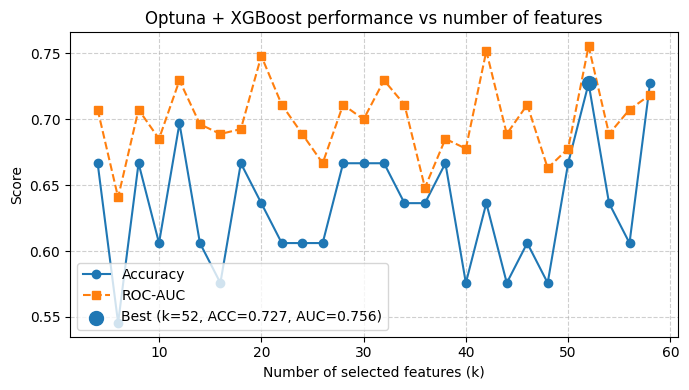

In [27]:
# Descriptors + Torsion
ranking = shap_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Descriptors + MACCS
ranking = shap_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.700 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.656 | ACC=0.545

=== Optuna: top 8 features ===
  AUC=0.641 | ACC=0.545

=== Optuna: top 10 features ===
  AUC=0.678 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.737 | ACC=0.606

=== Optuna: top 14 features ===
  AUC=0.707 | ACC=0.636

=== Optuna: top 16 features ===
  AUC=0.704 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.674 | ACC=0.606

=== Optuna: top 20 features ===
  AUC=0.763 | ACC=0.697

=== Optuna: top 22 features ===
  AUC=0.748 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.678 | ACC=0.606

=== Optuna: top 26 features ===
  AUC=0.663 | ACC=0.606

=== Optuna: top 28 features ===
  AUC=0.700 | ACC=0.636

=== Optuna: top 30 features ===
  AUC=0.733 | ACC=0.697

=== Optuna: top 32 features ===
  AUC=0.722 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.685 | ACC=0.697

=== Optuna: top 36 features ===
  AUC=0.700 | ACC=0.667

=== Optuna: top 38 features ===
 

## Model XGB Features Tuning (Optuna CV)

In [29]:
# Descriptors
ranking = xgb_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.581 | ACC=0.515

=== Optuna: top 6 features ===
  AUC=0.589 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.652 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.633 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.596 | ACC=0.576

=== Optuna: top 14 features ===
  AUC=0.652 | ACC=0.545

=== Optuna: top 16 features ===
  AUC=0.644 | ACC=0.606

=== Optuna: top 18 features ===
  AUC=0.619 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.637 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.630 | ACC=0.576

=== Optuna: top 24 features ===
  AUC=0.663 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.607 | ACC=0.606

=== Optuna: top 28 features ===
  AUC=0.663 | ACC=0.606

=== Optuna: top 30 features ===
  AUC=0.663 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.648 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.667 | ACC=0.606

=== Optuna: top 36 features ===
  AUC=0.626 | ACC=0.606

=== Optuna: top 38 features ===
 


=== Optuna: top 4 features ===
  AUC=0.548 | ACC=0.424

=== Optuna: top 6 features ===
  AUC=0.604 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.615 | ACC=0.545

=== Optuna: top 10 features ===
  AUC=0.622 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.596 | ACC=0.606

=== Optuna: top 14 features ===
  AUC=0.630 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.602 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.674 | ACC=0.606

=== Optuna: top 20 features ===
  AUC=0.633 | ACC=0.636

=== Optuna: top 22 features ===
  AUC=0.648 | ACC=0.606

=== Optuna: top 24 features ===
  AUC=0.652 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.607 | ACC=0.545

=== Optuna: top 28 features ===
  AUC=0.652 | ACC=0.576

=== Optuna: top 30 features ===
  AUC=0.656 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.652 | ACC=0.576

=== Optuna: top 34 features ===
  AUC=0.667 | ACC=0.576

=== Optuna: top 36 features ===
  AUC=0.670 | ACC=0.667

=== Optuna: top 38 features ===
 

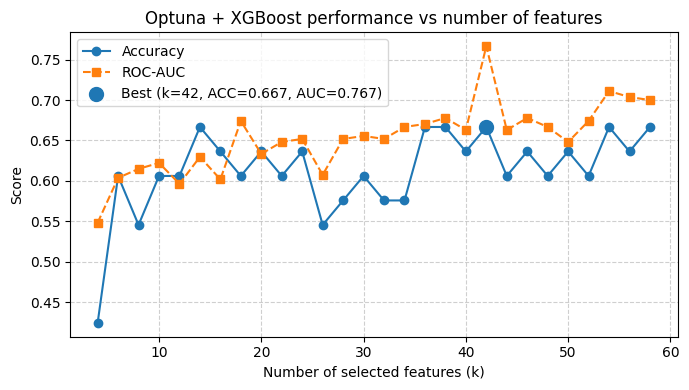

In [30]:
# Descriptors + Morgan
ranking = xgb_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.626 | ACC=0.576

=== Optuna: top 6 features ===
  AUC=0.663 | ACC=0.636

=== Optuna: top 8 features ===
  AUC=0.667 | ACC=0.636

=== Optuna: top 10 features ===
  AUC=0.700 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.637 | ACC=0.545

=== Optuna: top 14 features ===
  AUC=0.652 | ACC=0.545

=== Optuna: top 16 features ===
  AUC=0.711 | ACC=0.667

=== Optuna: top 18 features ===
  AUC=0.704 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.722 | ACC=0.667

=== Optuna: top 22 features ===
  AUC=0.667 | ACC=0.576

=== Optuna: top 24 features ===
  AUC=0.722 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.700 | ACC=0.636

=== Optuna: top 30 features ===
  AUC=0.644 | ACC=0.545

=== Optuna: top 32 features ===
  AUC=0.741 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.726 | ACC=0.667

=== Optuna: top 36 features ===
  AUC=0.696 | ACC=0.606

=== Optuna: top 38 features ===
 

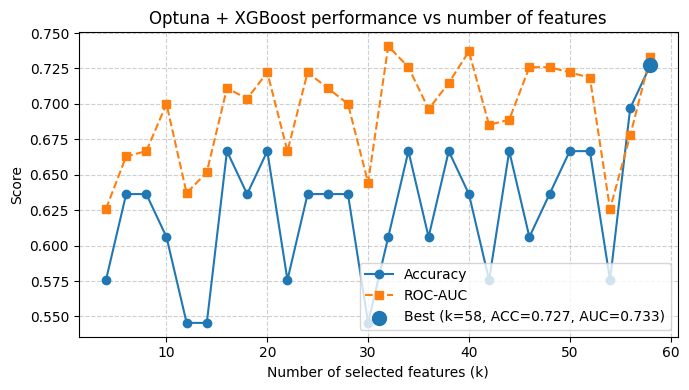

In [31]:
# Descriptors + AtomPair
ranking = xgb_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.700 | ACC=0.576

=== Optuna: top 6 features ===
  AUC=0.670 | ACC=0.545

=== Optuna: top 8 features ===
  AUC=0.711 | ACC=0.576

=== Optuna: top 10 features ===
  AUC=0.622 | ACC=0.636

=== Optuna: top 12 features ===
  AUC=0.774 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.767 | ACC=0.697

=== Optuna: top 16 features ===
  AUC=0.696 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.748 | ACC=0.697

=== Optuna: top 20 features ===
  AUC=0.759 | ACC=0.667

=== Optuna: top 22 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 24 features ===
  AUC=0.696 | ACC=0.576

=== Optuna: top 26 features ===
  AUC=0.744 | ACC=0.697

=== Optuna: top 28 features ===
  AUC=0.722 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.704 | ACC=0.636

=== Optuna: top 32 features ===
  AUC=0.715 | ACC=0.667

=== Optuna: top 34 features ===
  AUC=0.689 | ACC=0.727

=== Optuna: top 36 features ===
  AUC=0.722 | ACC=0.667

=== Optuna: top 38 features ===
 

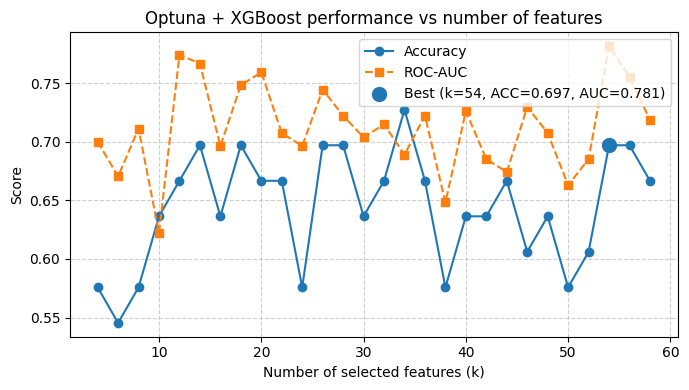

In [32]:
# Descriptors + RDkit
ranking = xgb_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Descriptors + Torsion
ranking = xgb_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.600 | ACC=0.576

=== Optuna: top 6 features ===
  AUC=0.630 | ACC=0.636

=== Optuna: top 8 features ===
  AUC=0.648 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.670 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.626 | ACC=0.636

=== Optuna: top 14 features ===
  AUC=0.635 | ACC=0.545

=== Optuna: top 16 features ===
  AUC=0.633 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.641 | ACC=0.606

=== Optuna: top 20 features ===
  AUC=0.641 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.633 | ACC=0.576

=== Optuna: top 24 features ===
  AUC=0.674 | ACC=0.606

=== Optuna: top 26 features ===
  AUC=0.641 | ACC=0.606

=== Optuna: top 28 features ===
  AUC=0.656 | ACC=0.667

=== Optuna: top 30 features ===
  AUC=0.656 | ACC=0.636

=== Optuna: top 32 features ===
  AUC=0.678 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.681 | ACC=0.606

=== Optuna: top 36 features ===
  AUC=0.685 | ACC=0.636

=== Optuna: top 38 features ===
 


=== Optuna: top 4 features ===
  AUC=0.656 | ACC=0.606

=== Optuna: top 6 features ===
  AUC=0.689 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.689 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.685 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.644 | ACC=0.606

=== Optuna: top 14 features ===
  AUC=0.685 | ACC=0.606

=== Optuna: top 16 features ===
  AUC=0.633 | ACC=0.576

=== Optuna: top 18 features ===
  AUC=0.659 | ACC=0.606

=== Optuna: top 20 features ===
  AUC=0.663 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.715 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.670 | ACC=0.606

=== Optuna: top 26 features ===
  AUC=0.659 | ACC=0.606

=== Optuna: top 28 features ===
  AUC=0.663 | ACC=0.606

=== Optuna: top 30 features ===
  AUC=0.693 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.633 | ACC=0.636

=== Optuna: top 34 features ===
  AUC=0.648 | ACC=0.606

=== Optuna: top 36 features ===
  AUC=0.756 | ACC=0.727

=== Optuna: top 38 features ===
 

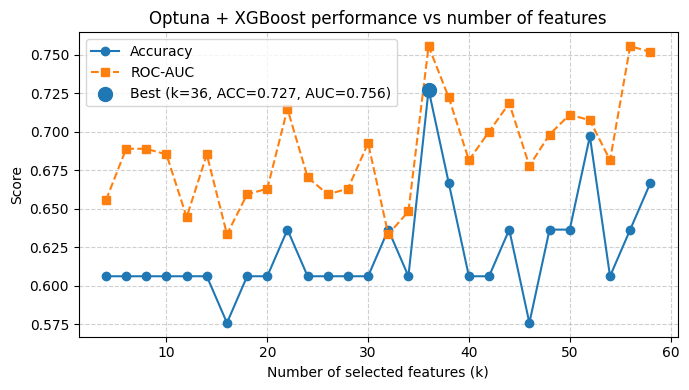

In [34]:
# Descriptors + MACCS
ranking = xgb_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Model KBEST Features Tuning (Optuna CV)

In [35]:
# Descriptors
ranking = kbest_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.728 | ACC=0.636

=== Optuna: top 6 features ===
  AUC=0.706 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.667 | ACC=0.667

=== Optuna: top 10 features ===
  AUC=0.670 | ACC=0.727

=== Optuna: top 12 features ===
  AUC=0.700 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.624 | ACC=0.576

=== Optuna: top 16 features ===
  AUC=0.663 | ACC=0.545

=== Optuna: top 18 features ===
  AUC=0.641 | ACC=0.576

=== Optuna: top 20 features ===
  AUC=0.685 | ACC=0.667

=== Optuna: top 22 features ===
  AUC=0.648 | ACC=0.697

=== Optuna: top 24 features ===
  AUC=0.585 | ACC=0.485

=== Optuna: top 26 features ===
  AUC=0.648 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.707 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.656 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.693 | ACC=0.606

=== Optuna: top 34 features ===
  AUC=0.737 | ACC=0.727

=== Optuna: top 36 features ===
  AUC=0.737 | ACC=0.636

=== Optuna: top 38 features ===
 

In [36]:
# Descriptors + Morgan
ranking = kbest_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.663 | ACC=0.636

=== Optuna: top 6 features ===
  AUC=0.667 | ACC=0.636

=== Optuna: top 8 features ===
  AUC=0.648 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.611 | ACC=0.636

=== Optuna: top 12 features ===
  AUC=0.663 | ACC=0.576

=== Optuna: top 14 features ===
  AUC=0.685 | ACC=0.576

=== Optuna: top 16 features ===
  AUC=0.593 | ACC=0.515

=== Optuna: top 18 features ===
  AUC=0.593 | ACC=0.576

=== Optuna: top 20 features ===
  AUC=0.674 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.717 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.667 | ACC=0.606

=== Optuna: top 26 features ===
  AUC=0.685 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.659 | ACC=0.576

=== Optuna: top 30 features ===
  AUC=0.693 | ACC=0.697

=== Optuna: top 32 features ===
  AUC=0.689 | ACC=0.636

=== Optuna: top 34 features ===
  AUC=0.719 | ACC=0.576

=== Optuna: top 36 features ===
  AUC=0.685 | ACC=0.576

=== Optuna: top 38 features ===
 


=== Optuna: top 4 features ===
  AUC=0.763 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.693 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.678 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.737 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.719 | ACC=0.636

=== Optuna: top 14 features ===
  AUC=0.681 | ACC=0.636

=== Optuna: top 16 features ===
  AUC=0.674 | ACC=0.545

=== Optuna: top 18 features ===
  AUC=0.663 | ACC=0.606

=== Optuna: top 20 features ===
  AUC=0.715 | ACC=0.576

=== Optuna: top 22 features ===
  AUC=0.607 | ACC=0.545

=== Optuna: top 24 features ===
  AUC=0.741 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.696 | ACC=0.606

=== Optuna: top 28 features ===
  AUC=0.737 | ACC=0.606

=== Optuna: top 30 features ===
  AUC=0.641 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.744 | ACC=0.636

=== Optuna: top 34 features ===
  AUC=0.696 | ACC=0.545

=== Optuna: top 36 features ===
  AUC=0.781 | ACC=0.636

=== Optuna: top 38 features ===
 

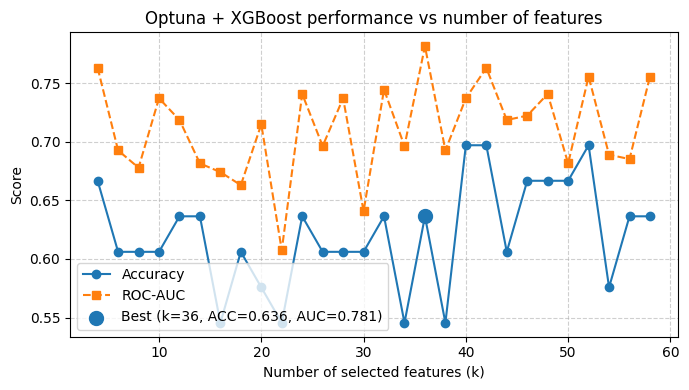

In [37]:
# Descriptors + AtomPair
ranking = kbest_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.722 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.656 | ACC=0.636

=== Optuna: top 8 features ===
  AUC=0.674 | ACC=0.697

=== Optuna: top 10 features ===
  AUC=0.715 | ACC=0.576

=== Optuna: top 12 features ===
  AUC=0.674 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.593 | ACC=0.545

=== Optuna: top 16 features ===
  AUC=0.748 | ACC=0.606

=== Optuna: top 18 features ===
  AUC=0.748 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.648 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.685 | ACC=0.576

=== Optuna: top 24 features ===
  AUC=0.733 | ACC=0.667

=== Optuna: top 26 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.719 | ACC=0.636

=== Optuna: top 30 features ===
  AUC=0.793 | ACC=0.636

=== Optuna: top 32 features ===
  AUC=0.748 | ACC=0.697

=== Optuna: top 34 features ===
  AUC=0.748 | ACC=0.636

=== Optuna: top 36 features ===
  AUC=0.767 | ACC=0.667

=== Optuna: top 38 features ===
 

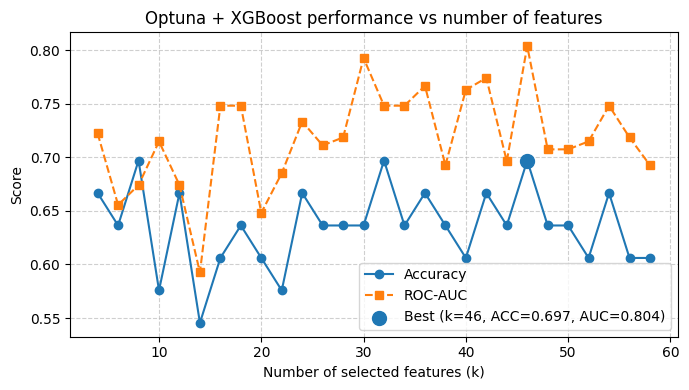

In [38]:
# Descriptors + RDkit
ranking = kbest_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Descriptors + Torsion
ranking = kbest_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.730 | ACC=0.636

=== Optuna: top 6 features ===
  AUC=0.726 | ACC=0.667

=== Optuna: top 8 features ===
  AUC=0.681 | ACC=0.667

=== Optuna: top 10 features ===
  AUC=0.667 | ACC=0.636

=== Optuna: top 12 features ===
  AUC=0.700 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.709 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.696 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.696 | ACC=0.727

=== Optuna: top 20 features ===
  AUC=0.715 | ACC=0.667

=== Optuna: top 22 features ===
  AUC=0.693 | ACC=0.636

=== Optuna: top 24 features ===
  AUC=0.667 | ACC=0.667

=== Optuna: top 26 features ===
  AUC=0.648 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.737 | ACC=0.667

=== Optuna: top 30 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 32 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 34 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 36 features ===
  AUC=0.681 | ACC=0.606

=== Optuna: top 38 features ===
 


=== Optuna: top 4 features ===
  AUC=0.728 | ACC=0.636

=== Optuna: top 6 features ===
  AUC=0.719 | ACC=0.667

=== Optuna: top 8 features ===
  AUC=0.656 | ACC=0.636

=== Optuna: top 10 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 12 features ===
  AUC=0.722 | ACC=0.636

=== Optuna: top 14 features ===
  AUC=0.700 | ACC=0.606

=== Optuna: top 16 features ===
  AUC=0.715 | ACC=0.636

=== Optuna: top 18 features ===
  AUC=0.693 | ACC=0.636

=== Optuna: top 20 features ===
  AUC=0.685 | ACC=0.606

=== Optuna: top 22 features ===
  AUC=0.578 | ACC=0.545

=== Optuna: top 24 features ===
  AUC=0.707 | ACC=0.697

=== Optuna: top 26 features ===
  AUC=0.715 | ACC=0.667

=== Optuna: top 28 features ===
  AUC=0.741 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.748 | ACC=0.727

=== Optuna: top 32 features ===
  AUC=0.670 | ACC=0.545

=== Optuna: top 34 features ===
  AUC=0.730 | ACC=0.667

=== Optuna: top 36 features ===
  AUC=0.726 | ACC=0.636

=== Optuna: top 38 features ===
 

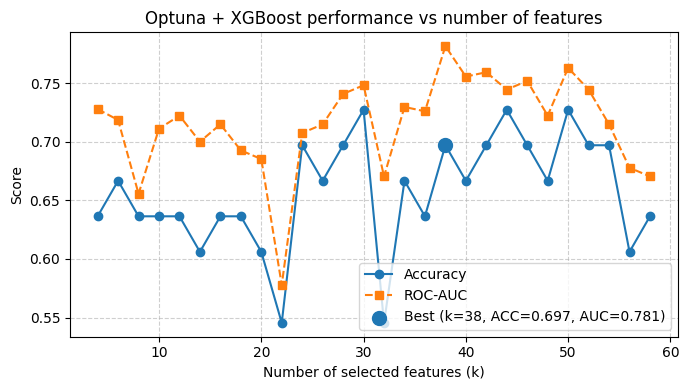

In [40]:
# Descriptors + MACCS
ranking = kbest_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Model LASSO Features Tuning (Optuna CV)


=== Optuna: top 4 features ===
  AUC=0.691 | ACC=0.697

=== Optuna: top 6 features ===
  AUC=0.681 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.778 | ACC=0.727

=== Optuna: top 10 features ===
  AUC=0.715 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.730 | ACC=0.636

=== Optuna: top 14 features ===
  AUC=0.770 | ACC=0.697

=== Optuna: top 16 features ===
  AUC=0.774 | ACC=0.758

=== Optuna: top 18 features ===
  AUC=0.767 | ACC=0.727

=== Optuna: top 20 features ===
  AUC=0.744 | ACC=0.697

=== Optuna: top 22 features ===
  AUC=0.767 | ACC=0.727

=== Optuna: top 24 features ===
  AUC=0.733 | ACC=0.727

=== Optuna: top 26 features ===
  AUC=0.752 | ACC=0.697

=== Optuna: top 28 features ===
  AUC=0.763 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.778 | ACC=0.758

=== Optuna: top 32 features ===
  AUC=0.767 | ACC=0.727

=== Optuna: top 34 features ===
  AUC=0.778 | ACC=0.758

=== Optuna: top 36 features ===
  AUC=0.759 | ACC=0.758

=== Optuna: top 38 features ===
 

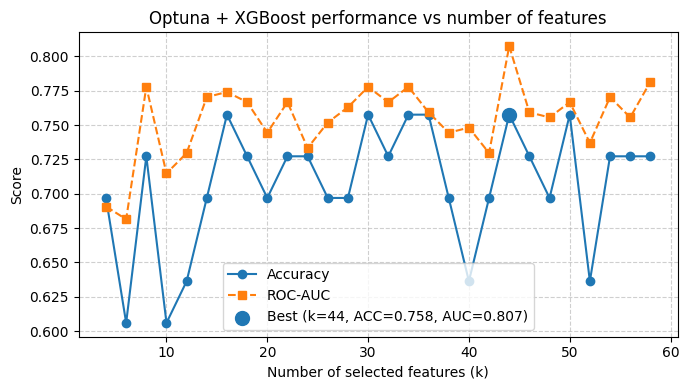

In [41]:
# Descriptors
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.693 | ACC=0.697

=== Optuna: top 6 features ===
  AUC=0.715 | ACC=0.697

=== Optuna: top 8 features ===
  AUC=0.711 | ACC=0.667

=== Optuna: top 10 features ===
  AUC=0.663 | ACC=0.727

=== Optuna: top 12 features ===
  AUC=0.630 | ACC=0.606

=== Optuna: top 14 features ===
  AUC=0.604 | ACC=0.606

=== Optuna: top 16 features ===
  AUC=0.722 | ACC=0.667

=== Optuna: top 18 features ===
  AUC=0.752 | ACC=0.727

=== Optuna: top 20 features ===
  AUC=0.726 | ACC=0.697

=== Optuna: top 22 features ===
  AUC=0.719 | ACC=0.697

=== Optuna: top 24 features ===
  AUC=0.722 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.719 | ACC=0.727

=== Optuna: top 28 features ===
  AUC=0.681 | ACC=0.667

=== Optuna: top 30 features ===
  AUC=0.733 | ACC=0.697

=== Optuna: top 32 features ===
  AUC=0.693 | ACC=0.545

=== Optuna: top 34 features ===
  AUC=0.726 | ACC=0.697

=== Optuna: top 36 features ===
  AUC=0.667 | ACC=0.606

=== Optuna: top 38 features ===
 

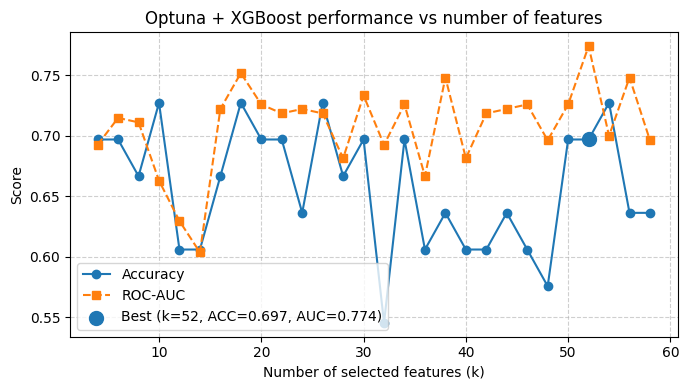

In [42]:
# Descriptors + Morgan
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.737 | ACC=0.667

=== Optuna: top 6 features ===
  AUC=0.770 | ACC=0.697

=== Optuna: top 8 features ===
  AUC=0.789 | ACC=0.727

=== Optuna: top 10 features ===
  AUC=0.793 | ACC=0.667

=== Optuna: top 12 features ===
  AUC=0.733 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.748 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.774 | ACC=0.758

=== Optuna: top 18 features ===
  AUC=0.733 | ACC=0.697

=== Optuna: top 20 features ===
  AUC=0.719 | ACC=0.667

=== Optuna: top 22 features ===
  AUC=0.737 | ACC=0.667

=== Optuna: top 24 features ===
  AUC=0.778 | ACC=0.697

=== Optuna: top 26 features ===
  AUC=0.726 | ACC=0.697

=== Optuna: top 28 features ===
  AUC=0.707 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.774 | ACC=0.758

=== Optuna: top 32 features ===
  AUC=0.778 | ACC=0.636

=== Optuna: top 34 features ===
  AUC=0.744 | ACC=0.697

=== Optuna: top 36 features ===
  AUC=0.741 | ACC=0.667

=== Optuna: top 38 features ===
 

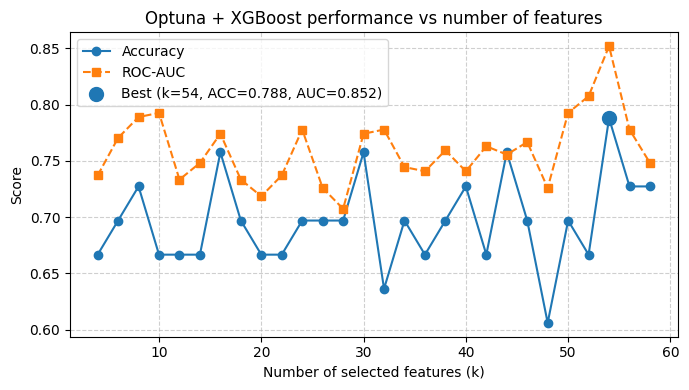

In [43]:
# Descriptors + AtomPair
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.726 | ACC=0.606

=== Optuna: top 6 features ===
  AUC=0.763 | ACC=0.727

=== Optuna: top 8 features ===
  AUC=0.726 | ACC=0.697

=== Optuna: top 10 features ===
  AUC=0.674 | ACC=0.606

=== Optuna: top 12 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.778 | ACC=0.727

=== Optuna: top 18 features ===
  AUC=0.789 | ACC=0.818

=== Optuna: top 20 features ===
  AUC=0.770 | ACC=0.727

=== Optuna: top 22 features ===
  AUC=0.763 | ACC=0.727

=== Optuna: top 24 features ===
  AUC=0.719 | ACC=0.636

=== Optuna: top 26 features ===
  AUC=0.770 | ACC=0.758

=== Optuna: top 28 features ===
  AUC=0.815 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.778 | ACC=0.667

=== Optuna: top 32 features ===
  AUC=0.707 | ACC=0.667

=== Optuna: top 34 features ===
  AUC=0.730 | ACC=0.636

=== Optuna: top 36 features ===
  AUC=0.763 | ACC=0.727

=== Optuna: top 38 features ===
 

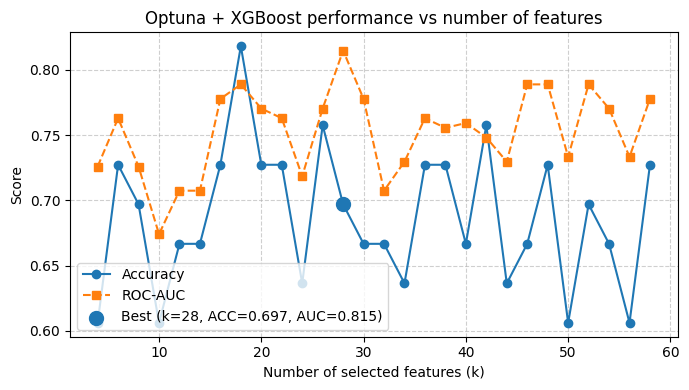

In [44]:
# Descriptors + RDkit
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.789 | ACC=0.758

=== Optuna: top 6 features ===
  AUC=0.815 | ACC=0.727

=== Optuna: top 8 features ===
  AUC=0.785 | ACC=0.697

=== Optuna: top 10 features ===
  AUC=0.785 | ACC=0.697

=== Optuna: top 12 features ===
  AUC=0.789 | ACC=0.788

=== Optuna: top 14 features ===
  AUC=0.733 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.778 | ACC=0.758

=== Optuna: top 18 features ===
  AUC=0.789 | ACC=0.727

=== Optuna: top 20 features ===
  AUC=0.711 | ACC=0.727

=== Optuna: top 22 features ===
  AUC=0.722 | ACC=0.697

=== Optuna: top 24 features ===
  AUC=0.774 | ACC=0.697

=== Optuna: top 26 features ===
  AUC=0.715 | ACC=0.727

=== Optuna: top 28 features ===
  AUC=0.752 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.759 | ACC=0.727

=== Optuna: top 32 features ===
  AUC=0.774 | ACC=0.758

=== Optuna: top 34 features ===
  AUC=0.781 | ACC=0.727

=== Optuna: top 36 features ===
  AUC=0.774 | ACC=0.697

=== Optuna: top 38 features ===
 

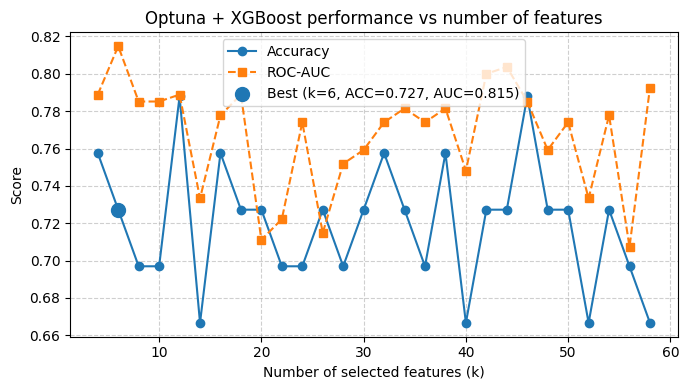

In [45]:
# Descriptors + Torsion
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.733 | ACC=0.576

=== Optuna: top 6 features ===
  AUC=0.689 | ACC=0.636

=== Optuna: top 8 features ===
  AUC=0.744 | ACC=0.606

=== Optuna: top 10 features ===
  AUC=0.707 | ACC=0.636

=== Optuna: top 12 features ===
  AUC=0.696 | ACC=0.636

=== Optuna: top 14 features ===
  AUC=0.667 | ACC=0.667

=== Optuna: top 16 features ===
  AUC=0.744 | ACC=0.606

=== Optuna: top 18 features ===
  AUC=0.674 | ACC=0.697

=== Optuna: top 20 features ===
  AUC=0.707 | ACC=0.636

=== Optuna: top 22 features ===
  AUC=0.756 | ACC=0.697

=== Optuna: top 24 features ===
  AUC=0.785 | ACC=0.697

=== Optuna: top 26 features ===
  AUC=0.715 | ACC=0.636

=== Optuna: top 28 features ===
  AUC=0.759 | ACC=0.636

=== Optuna: top 30 features ===
  AUC=0.752 | ACC=0.727

=== Optuna: top 32 features ===
  AUC=0.726 | ACC=0.727

=== Optuna: top 34 features ===
  AUC=0.737 | ACC=0.697

=== Optuna: top 36 features ===
  AUC=0.778 | ACC=0.697

=== Optuna: top 38 features ===
 

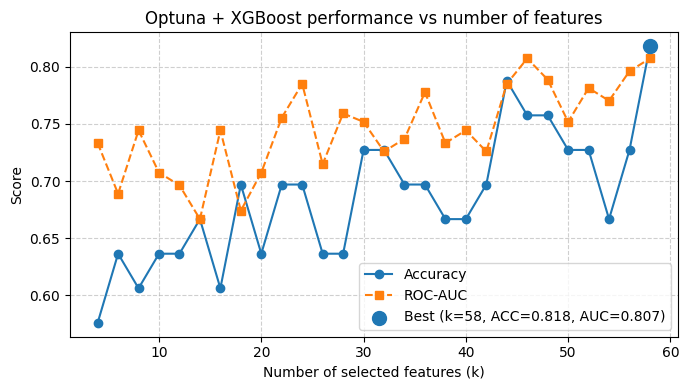

In [104]:
# Descriptors + MACCS
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Descriptors + MACCS
ranking = lasso_features

optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== Optuna: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Objective for Optuna
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 20, 120),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_sel,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)

    best_params = study.best_params

    # Train final model on full train subset with best params
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        **best_params
    )
    final_model.fit(X_train_sel, y_train)

    # Test-set evaluation
    y_pred = final_model.predict(X_test_sel)
    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Store results for this k
    optuna_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

optuna_df = pd.DataFrame(optuna_results)

# Maximize AUC
max_auc = optuna_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = optuna_df[np.abs(optuna_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC:")
print(f"  k = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(optuna_df["k"], optuna_df["accuracy"], "o-", label="Accuracy")
plt.plot(optuna_df["k"], optuna_df["auc"], "s--", label="ROC-AUC")

# Highlight best k on plot
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("Optuna + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Optuna: top 4 features ===
  AUC=0.704 | ACC=0.636

=== Optuna: top 6 features ===
  AUC=0.711 | ACC=0.606

=== Optuna: top 8 features ===
  AUC=0.689 | ACC=0.636

=== Optuna: top 10 features ===
  AUC=0.715 | ACC=0.667

=== Optuna: top 12 features ===
  AUC=0.696 | ACC=0.667

=== Optuna: top 14 features ===
  AUC=0.748 | ACC=0.636

=== Optuna: top 16 features ===
  AUC=0.726 | ACC=0.667

=== Optuna: top 18 features ===
  AUC=0.733 | ACC=0.667

=== Optuna: top 20 features ===
  AUC=0.722 | ACC=0.667

=== Optuna: top 22 features ===
  AUC=0.704 | ACC=0.667

=== Optuna: top 24 features ===
  AUC=0.722 | ACC=0.606

=== Optuna: top 26 features ===
  AUC=0.726 | ACC=0.727

=== Optuna: top 28 features ===
  AUC=0.778 | ACC=0.697

=== Optuna: top 30 features ===
  AUC=0.789 | ACC=0.606

=== Optuna: top 32 features ===
  AUC=0.711 | ACC=0.636

=== Optuna: top 34 features ===
  AUC=0.737 | ACC=0.667

=== Optuna: top 36 features ===
  AUC=0.800 | ACC=0.758

=== Optuna: top 38 features ===
 

## Model SHAP Features Tuning (Randomized Search CV)

In [47]:
# Descriptors
ranking = shap_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k descriptor features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel  = X_test[top_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.633 | ACC=0.636

=== RandomizedSearchCV: top 6 features ===
  AUC=0.681 | ACC=0.576

=== RandomizedSearchCV: top 8 features ===
  AUC=0.674 | ACC=0.455

=== RandomizedSearchCV: top 10 features ===
  AUC=0.652 | ACC=0.576

=== RandomizedSearchCV: top 12 features ===
  AUC=0.696 | ACC=0.576

=== RandomizedSearchCV: top 14 features ===
  AUC=0.696 | ACC=0.667

=== RandomizedSearchCV: top 16 features ===
  AUC=0.715 | ACC=0.667

=== RandomizedSearchCV: top 18 features ===
  AUC=0.667 | ACC=0.606

=== RandomizedSearchCV: top 20 features ===
  AUC=0.685 | ACC=0.636

=== RandomizedSearchCV: top 22 features ===
  AUC=0.678 | ACC=0.636

=== RandomizedSearchCV: top 24 features ===
  AUC=0.663 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.670 | ACC=0.576

=== RandomizedSearchCV: top 28 features ===
  AUC=0.674 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 32 featu


=== RandomizedSearchCV: top 4 features ===
  AUC=0.648 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.619 | ACC=0.545

=== RandomizedSearchCV: top 8 features ===
  AUC=0.656 | ACC=0.576

=== RandomizedSearchCV: top 10 features ===
  AUC=0.644 | ACC=0.515

=== RandomizedSearchCV: top 12 features ===
  AUC=0.681 | ACC=0.636

=== RandomizedSearchCV: top 14 features ===
  AUC=0.704 | ACC=0.697

=== RandomizedSearchCV: top 16 features ===
  AUC=0.637 | ACC=0.545

=== RandomizedSearchCV: top 18 features ===
  AUC=0.630 | ACC=0.606

=== RandomizedSearchCV: top 20 features ===
  AUC=0.689 | ACC=0.636

=== RandomizedSearchCV: top 22 features ===
  AUC=0.652 | ACC=0.606

=== RandomizedSearchCV: top 24 features ===
  AUC=0.659 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.659 | ACC=0.606

=== RandomizedSearchCV: top 28 features ===
  AUC=0.637 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.707 | ACC=0.667

=== RandomizedSearchCV: top 32 featu

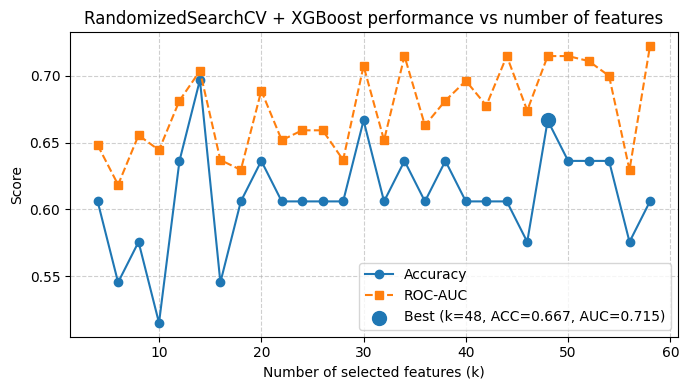

In [48]:
# Descriptors + Morgan
ranking = shap_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.674 | ACC=0.576

=== RandomizedSearchCV: top 6 features ===
  AUC=0.656 | ACC=0.515

=== RandomizedSearchCV: top 8 features ===
  AUC=0.759 | ACC=0.697

=== RandomizedSearchCV: top 10 features ===
  AUC=0.733 | ACC=0.606

=== RandomizedSearchCV: top 12 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 14 features ===
  AUC=0.719 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.719 | ACC=0.606

=== RandomizedSearchCV: top 18 features ===
  AUC=0.685 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.719 | ACC=0.606

=== RandomizedSearchCV: top 22 features ===
  AUC=0.715 | ACC=0.667

=== RandomizedSearchCV: top 24 features ===
  AUC=0.670 | ACC=0.545

=== RandomizedSearchCV: top 26 features ===
  AUC=0.689 | ACC=0.606

=== RandomizedSearchCV: top 28 features ===
  AUC=0.678 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.726 | ACC=0.606

=== RandomizedSearchCV: top 32 featu

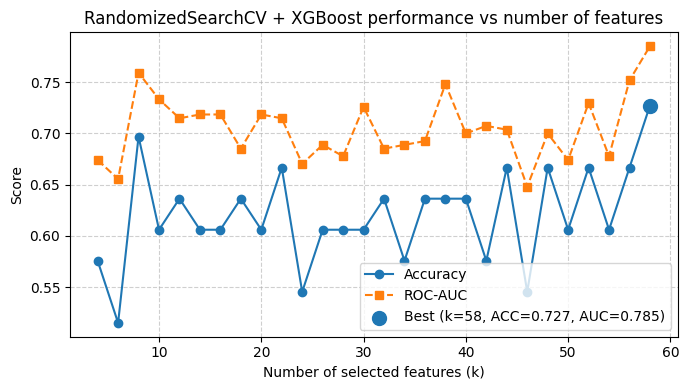

In [49]:
# Descriptors + Atompair
ranking = shap_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.689 | ACC=0.636

=== RandomizedSearchCV: top 6 features ===
  AUC=0.696 | ACC=0.636

=== RandomizedSearchCV: top 8 features ===
  AUC=0.678 | ACC=0.606

=== RandomizedSearchCV: top 10 features ===
  AUC=0.730 | ACC=0.576

=== RandomizedSearchCV: top 12 features ===
  AUC=0.722 | ACC=0.576

=== RandomizedSearchCV: top 14 features ===
  AUC=0.685 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.733 | ACC=0.667

=== RandomizedSearchCV: top 18 features ===
  AUC=0.726 | ACC=0.667

=== RandomizedSearchCV: top 20 features ===
  AUC=0.693 | ACC=0.576

=== RandomizedSearchCV: top 22 features ===
  AUC=0.707 | ACC=0.636

=== RandomizedSearchCV: top 24 features ===
  AUC=0.704 | ACC=0.697

=== RandomizedSearchCV: top 26 features ===
  AUC=0.696 | ACC=0.636

=== RandomizedSearchCV: top 28 features ===
  AUC=0.726 | ACC=0.667

=== RandomizedSearchCV: top 30 features ===
  AUC=0.719 | ACC=0.727

=== RandomizedSearchCV: top 32 featu

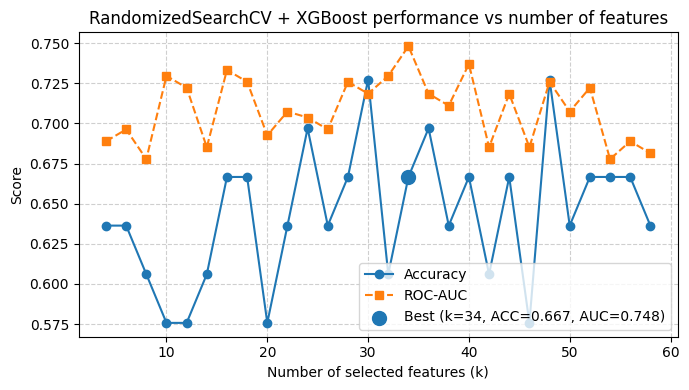

In [50]:
# Descriptors + RDkit
ranking = shap_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.615 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.648 | ACC=0.545

=== RandomizedSearchCV: top 8 features ===
  AUC=0.707 | ACC=0.606

=== RandomizedSearchCV: top 10 features ===
  AUC=0.722 | ACC=0.606

=== RandomizedSearchCV: top 12 features ===
  AUC=0.681 | ACC=0.606

=== RandomizedSearchCV: top 14 features ===
  AUC=0.726 | ACC=0.667

=== RandomizedSearchCV: top 16 features ===
  AUC=0.711 | ACC=0.636

=== RandomizedSearchCV: top 18 features ===
  AUC=0.767 | ACC=0.697

=== RandomizedSearchCV: top 20 features ===
  AUC=0.733 | ACC=0.636

=== RandomizedSearchCV: top 22 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 24 features ===
  AUC=0.656 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.693 | ACC=0.606

=== RandomizedSearchCV: top 28 features ===
  AUC=0.663 | ACC=0.576

=== RandomizedSearchCV: top 30 features ===
  AUC=0.685 | ACC=0.606

=== RandomizedSearchCV: top 32 featu

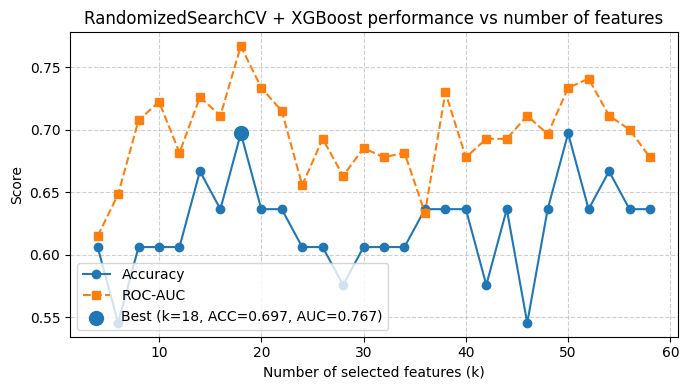

In [51]:
# Descriptors + Torsion
ranking = shap_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.656 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.648 | ACC=0.576

=== RandomizedSearchCV: top 8 features ===
  AUC=0.674 | ACC=0.576

=== RandomizedSearchCV: top 10 features ===
  AUC=0.674 | ACC=0.485

=== RandomizedSearchCV: top 12 features ===
  AUC=0.752 | ACC=0.667

=== RandomizedSearchCV: top 14 features ===
  AUC=0.689 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.693 | ACC=0.667

=== RandomizedSearchCV: top 18 features ===
  AUC=0.681 | ACC=0.606

=== RandomizedSearchCV: top 20 features ===
  AUC=0.726 | ACC=0.606

=== RandomizedSearchCV: top 22 features ===
  AUC=0.737 | ACC=0.636

=== RandomizedSearchCV: top 24 features ===
  AUC=0.681 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.674 | ACC=0.576

=== RandomizedSearchCV: top 28 features ===
  AUC=0.689 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.733 | ACC=0.636

=== RandomizedSearchCV: top 32 featu

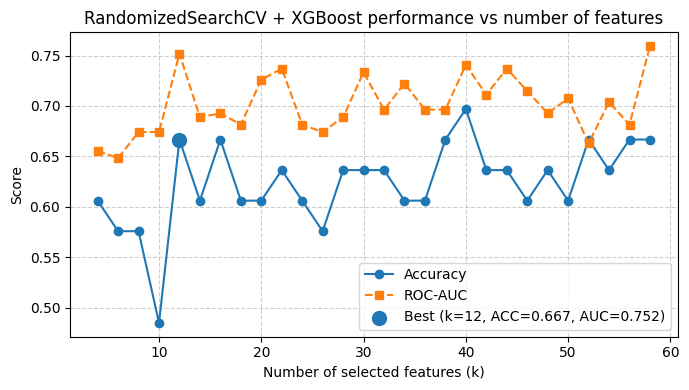

In [52]:
# Descriptors + MACCS
ranking = shap_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Model XGB Features Tuning (Randomized Search CV)


=== RandomizedSearchCV: top 4 features ===
  AUC=0.511 | ACC=0.545

=== RandomizedSearchCV: top 6 features ===
  AUC=0.570 | ACC=0.636

=== RandomizedSearchCV: top 8 features ===
  AUC=0.656 | ACC=0.636

=== RandomizedSearchCV: top 10 features ===
  AUC=0.611 | ACC=0.515

=== RandomizedSearchCV: top 12 features ===
  AUC=0.626 | ACC=0.667

=== RandomizedSearchCV: top 14 features ===
  AUC=0.644 | ACC=0.636

=== RandomizedSearchCV: top 16 features ===
  AUC=0.630 | ACC=0.697

=== RandomizedSearchCV: top 18 features ===
  AUC=0.648 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.656 | ACC=0.606

=== RandomizedSearchCV: top 22 features ===
  AUC=0.663 | ACC=0.697

=== RandomizedSearchCV: top 24 features ===
  AUC=0.648 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.637 | ACC=0.636

=== RandomizedSearchCV: top 28 features ===
  AUC=0.641 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.652 | ACC=0.667

=== RandomizedSearchCV: top 32 featu

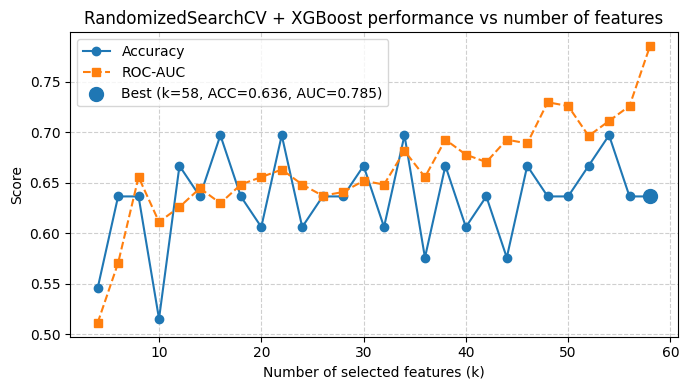

In [53]:
# Descriptors
ranking = xgb_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k descriptor features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel  = X_test[top_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.578 | ACC=0.515

=== RandomizedSearchCV: top 6 features ===
  AUC=0.637 | ACC=0.636

=== RandomizedSearchCV: top 8 features ===
  AUC=0.644 | ACC=0.606

=== RandomizedSearchCV: top 10 features ===
  AUC=0.641 | ACC=0.576

=== RandomizedSearchCV: top 12 features ===
  AUC=0.656 | ACC=0.606

=== RandomizedSearchCV: top 14 features ===
  AUC=0.674 | ACC=0.697

=== RandomizedSearchCV: top 16 features ===
  AUC=0.619 | ACC=0.636

=== RandomizedSearchCV: top 18 features ===
  AUC=0.630 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.593 | ACC=0.606

=== RandomizedSearchCV: top 22 features ===
  AUC=0.619 | ACC=0.606

=== RandomizedSearchCV: top 24 features ===
  AUC=0.659 | ACC=0.636

=== RandomizedSearchCV: top 26 features ===
  AUC=0.652 | ACC=0.636

=== RandomizedSearchCV: top 28 features ===
  AUC=0.704 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.656 | ACC=0.667

=== RandomizedSearchCV: top 32 featu

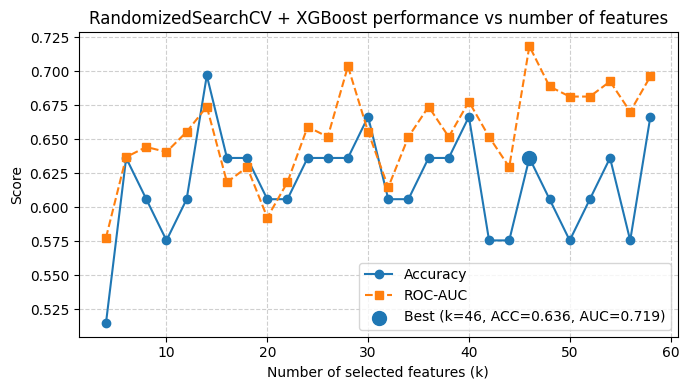

In [54]:
# Descriptors + Morgan
ranking = xgb_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
# Descriptors + Atompair
ranking = xgb_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.689 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.685 | ACC=0.576

=== RandomizedSearchCV: top 8 features ===
  AUC=0.685 | ACC=0.606

=== RandomizedSearchCV: top 10 features ===
  AUC=0.707 | ACC=0.727

=== RandomizedSearchCV: top 12 features ===
  AUC=0.696 | ACC=0.636

=== RandomizedSearchCV: top 14 features ===
  AUC=0.678 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.741 | ACC=0.697

=== RandomizedSearchCV: top 18 features ===
  AUC=0.641 | ACC=0.576

=== RandomizedSearchCV: top 20 features ===
  AUC=0.704 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.696 | ACC=0.606

=== RandomizedSearchCV: top 24 features ===
  AUC=0.763 | ACC=0.727

=== RandomizedSearchCV: top 26 features ===
  AUC=0.704 | ACC=0.636

=== RandomizedSearchCV: top 28 features ===
  AUC=0.700 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.737 | ACC=0.606

=== RandomizedSearchCV: top 32 featu


=== RandomizedSearchCV: top 4 features ===
  AUC=0.667 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.748 | ACC=0.636

=== RandomizedSearchCV: top 8 features ===
  AUC=0.678 | ACC=0.576

=== RandomizedSearchCV: top 10 features ===
  AUC=0.685 | ACC=0.667

=== RandomizedSearchCV: top 12 features ===
  AUC=0.748 | ACC=0.667

=== RandomizedSearchCV: top 14 features ===
  AUC=0.759 | ACC=0.667

=== RandomizedSearchCV: top 16 features ===
  AUC=0.770 | ACC=0.697

=== RandomizedSearchCV: top 18 features ===
  AUC=0.722 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.733 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.815 | ACC=0.697

=== RandomizedSearchCV: top 24 features ===
  AUC=0.693 | ACC=0.636

=== RandomizedSearchCV: top 26 features ===
  AUC=0.685 | ACC=0.636

=== RandomizedSearchCV: top 28 features ===
  AUC=0.678 | ACC=0.667

=== RandomizedSearchCV: top 30 features ===
  AUC=0.681 | ACC=0.667

=== RandomizedSearchCV: top 32 featu

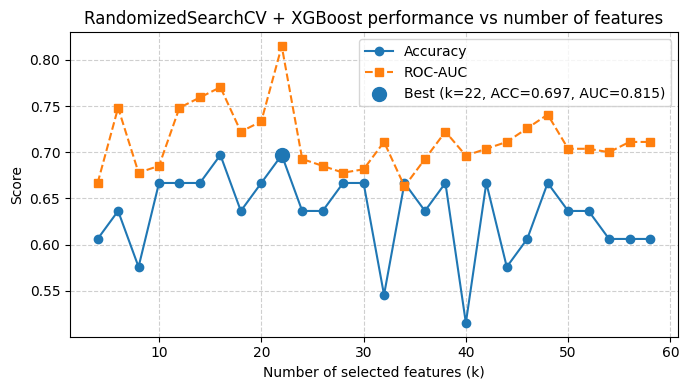

In [56]:
# Descriptors + RDkit
ranking = xgb_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.633 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.648 | ACC=0.606

=== RandomizedSearchCV: top 8 features ===
  AUC=0.674 | ACC=0.606

=== RandomizedSearchCV: top 10 features ===
  AUC=0.674 | ACC=0.636

=== RandomizedSearchCV: top 12 features ===
  AUC=0.652 | ACC=0.667

=== RandomizedSearchCV: top 14 features ===
  AUC=0.670 | ACC=0.667

=== RandomizedSearchCV: top 16 features ===
  AUC=0.696 | ACC=0.636

=== RandomizedSearchCV: top 18 features ===
  AUC=0.689 | ACC=0.697

=== RandomizedSearchCV: top 20 features ===
  AUC=0.722 | ACC=0.697

=== RandomizedSearchCV: top 22 features ===
  AUC=0.630 | ACC=0.606

=== RandomizedSearchCV: top 24 features ===
  AUC=0.670 | ACC=0.636

=== RandomizedSearchCV: top 26 features ===
  AUC=0.685 | ACC=0.606

=== RandomizedSearchCV: top 28 features ===
  AUC=0.674 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.674 | ACC=0.667

=== RandomizedSearchCV: top 32 featu

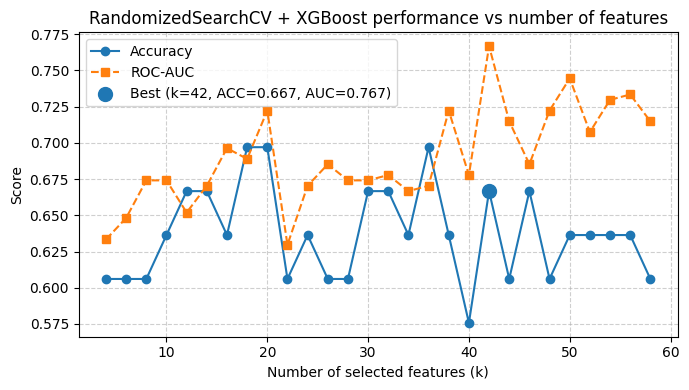

In [57]:
# Descriptors + Torsion
ranking = xgb_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# Descriptors + MACCS
ranking = xgb_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.689 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.681 | ACC=0.606

=== RandomizedSearchCV: top 8 features ===
  AUC=0.756 | ACC=0.667

=== RandomizedSearchCV: top 10 features ===
  AUC=0.644 | ACC=0.606

=== RandomizedSearchCV: top 12 features ===
  AUC=0.670 | ACC=0.606

=== RandomizedSearchCV: top 14 features ===
  AUC=0.674 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.693 | ACC=0.545

=== RandomizedSearchCV: top 18 features ===
  AUC=0.704 | ACC=0.667

=== RandomizedSearchCV: top 20 features ===
  AUC=0.659 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.719 | ACC=0.636

=== RandomizedSearchCV: top 24 features ===
  AUC=0.674 | ACC=0.667

=== RandomizedSearchCV: top 26 features ===
  AUC=0.667 | ACC=0.667

=== RandomizedSearchCV: top 28 features ===
  AUC=0.707 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.707 | ACC=0.667

=== RandomizedSearchCV: top 32 featu

## Model KBEST Features Tuning (Randomized Search CV)

In [59]:
# Descriptors
ranking = kbest_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k descriptor features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel  = X_test[top_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.707 | ACC=0.576

=== RandomizedSearchCV: top 6 features ===
  AUC=0.706 | ACC=0.606

=== RandomizedSearchCV: top 8 features ===
  AUC=0.648 | ACC=0.606

=== RandomizedSearchCV: top 10 features ===
  AUC=0.644 | ACC=0.606

=== RandomizedSearchCV: top 12 features ===
  AUC=0.626 | ACC=0.576

=== RandomizedSearchCV: top 14 features ===
  AUC=0.641 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.681 | ACC=0.576

=== RandomizedSearchCV: top 18 features ===
  AUC=0.626 | ACC=0.576

=== RandomizedSearchCV: top 20 features ===
  AUC=0.604 | ACC=0.576

=== RandomizedSearchCV: top 22 features ===
  AUC=0.670 | ACC=0.576

=== RandomizedSearchCV: top 24 features ===
  AUC=0.681 | ACC=0.576

=== RandomizedSearchCV: top 26 features ===
  AUC=0.633 | ACC=0.545

=== RandomizedSearchCV: top 28 features ===
  AUC=0.670 | ACC=0.576

=== RandomizedSearchCV: top 30 features ===
  AUC=0.681 | ACC=0.576

=== RandomizedSearchCV: top 32 featu

In [60]:
# Descriptors + Morgan
ranking = kbest_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.670 | ACC=0.606

=== RandomizedSearchCV: top 6 features ===
  AUC=0.683 | ACC=0.576

=== RandomizedSearchCV: top 8 features ===
  AUC=0.633 | ACC=0.545

=== RandomizedSearchCV: top 10 features ===
  AUC=0.663 | ACC=0.576

=== RandomizedSearchCV: top 12 features ===
  AUC=0.674 | ACC=0.576

=== RandomizedSearchCV: top 14 features ===
  AUC=0.633 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.659 | ACC=0.606

=== RandomizedSearchCV: top 18 features ===
  AUC=0.685 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.656 | ACC=0.576

=== RandomizedSearchCV: top 22 features ===
  AUC=0.648 | ACC=0.606

=== RandomizedSearchCV: top 24 features ===
  AUC=0.607 | ACC=0.485

=== RandomizedSearchCV: top 26 features ===
  AUC=0.685 | ACC=0.606

=== RandomizedSearchCV: top 28 features ===
  AUC=0.630 | ACC=0.545

=== RandomizedSearchCV: top 30 features ===
  AUC=0.674 | ACC=0.636

=== RandomizedSearchCV: top 32 featu


=== RandomizedSearchCV: top 4 features ===
  AUC=0.633 | ACC=0.576

=== RandomizedSearchCV: top 6 features ===
  AUC=0.700 | ACC=0.576

=== RandomizedSearchCV: top 8 features ===
  AUC=0.648 | ACC=0.636

=== RandomizedSearchCV: top 10 features ===
  AUC=0.689 | ACC=0.636

=== RandomizedSearchCV: top 12 features ===
  AUC=0.663 | ACC=0.545

=== RandomizedSearchCV: top 14 features ===
  AUC=0.656 | ACC=0.636

=== RandomizedSearchCV: top 16 features ===
  AUC=0.689 | ACC=0.606

=== RandomizedSearchCV: top 18 features ===
  AUC=0.726 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.704 | ACC=0.576

=== RandomizedSearchCV: top 22 features ===
  AUC=0.652 | ACC=0.545

=== RandomizedSearchCV: top 24 features ===
  AUC=0.733 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.707 | ACC=0.667

=== RandomizedSearchCV: top 28 features ===
  AUC=0.719 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.663 | ACC=0.606

=== RandomizedSearchCV: top 32 featu

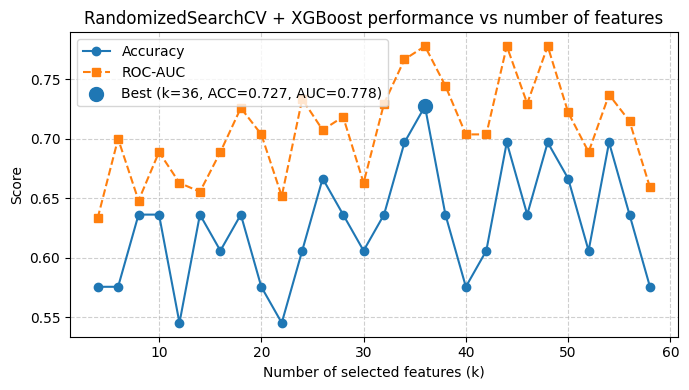

In [61]:
# Descriptors + Atompair
ranking = kbest_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.693 | ACC=0.636

=== RandomizedSearchCV: top 6 features ===
  AUC=0.722 | ACC=0.636

=== RandomizedSearchCV: top 8 features ===
  AUC=0.737 | ACC=0.667

=== RandomizedSearchCV: top 10 features ===
  AUC=0.744 | ACC=0.667

=== RandomizedSearchCV: top 12 features ===
  AUC=0.656 | ACC=0.636

=== RandomizedSearchCV: top 14 features ===
  AUC=0.674 | ACC=0.636

=== RandomizedSearchCV: top 16 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 18 features ===
  AUC=0.719 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.656 | ACC=0.606

=== RandomizedSearchCV: top 22 features ===
  AUC=0.730 | ACC=0.667

=== RandomizedSearchCV: top 24 features ===
  AUC=0.715 | ACC=0.545

=== RandomizedSearchCV: top 26 features ===
  AUC=0.719 | ACC=0.606

=== RandomizedSearchCV: top 28 features ===
  AUC=0.696 | ACC=0.576

=== RandomizedSearchCV: top 30 features ===
  AUC=0.759 | ACC=0.606

=== RandomizedSearchCV: top 32 featu

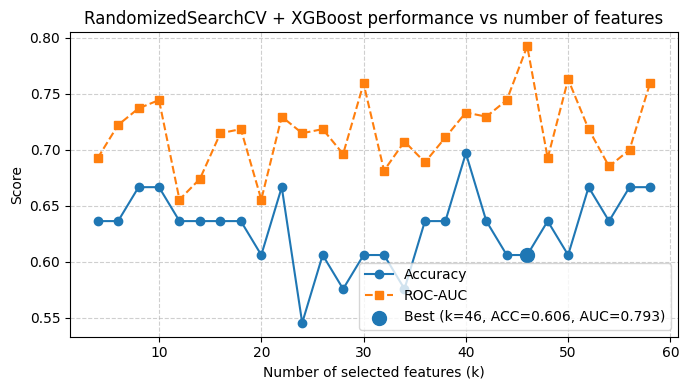

In [62]:
# Descriptors + RDkit
ranking = kbest_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.763 | ACC=0.667

=== RandomizedSearchCV: top 6 features ===
  AUC=0.704 | ACC=0.667

=== RandomizedSearchCV: top 8 features ===
  AUC=0.674 | ACC=0.636

=== RandomizedSearchCV: top 10 features ===
  AUC=0.715 | ACC=0.667

=== RandomizedSearchCV: top 12 features ===
  AUC=0.704 | ACC=0.545

=== RandomizedSearchCV: top 14 features ===
  AUC=0.650 | ACC=0.545

=== RandomizedSearchCV: top 16 features ===
  AUC=0.737 | ACC=0.727

=== RandomizedSearchCV: top 18 features ===
  AUC=0.670 | ACC=0.667

=== RandomizedSearchCV: top 20 features ===
  AUC=0.700 | ACC=0.606

=== RandomizedSearchCV: top 22 features ===
  AUC=0.719 | ACC=0.636

=== RandomizedSearchCV: top 24 features ===
  AUC=0.667 | ACC=0.576

=== RandomizedSearchCV: top 26 features ===
  AUC=0.637 | ACC=0.697

=== RandomizedSearchCV: top 28 features ===
  AUC=0.704 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.619 | ACC=0.515

=== RandomizedSearchCV: top 32 featu

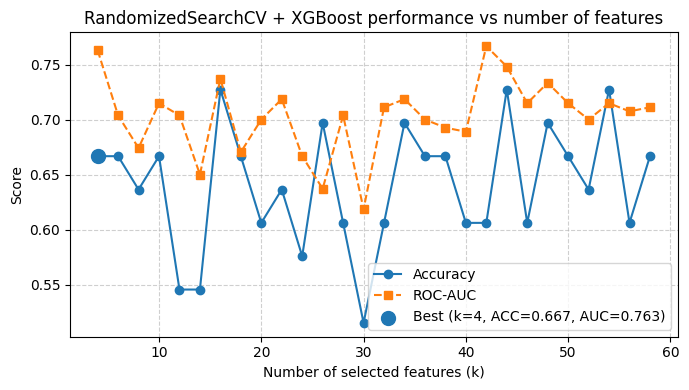

In [63]:
# Descriptors + Torsion
ranking = kbest_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 6 features ===
  AUC=0.704 | ACC=0.545

=== RandomizedSearchCV: top 8 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 10 features ===
  AUC=0.659 | ACC=0.576

=== RandomizedSearchCV: top 12 features ===
  AUC=0.678 | ACC=0.576

=== RandomizedSearchCV: top 14 features ===
  AUC=0.693 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.670 | ACC=0.606

=== RandomizedSearchCV: top 18 features ===
  AUC=0.674 | ACC=0.606

=== RandomizedSearchCV: top 20 features ===
  AUC=0.656 | ACC=0.576

=== RandomizedSearchCV: top 22 features ===
  AUC=0.704 | ACC=0.576

=== RandomizedSearchCV: top 24 features ===
  AUC=0.663 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.630 | ACC=0.545

=== RandomizedSearchCV: top 28 features ===
  AUC=0.689 | ACC=0.697

=== RandomizedSearchCV: top 30 features ===
  AUC=0.681 | ACC=0.606

=== RandomizedSearchCV: top 32 featu

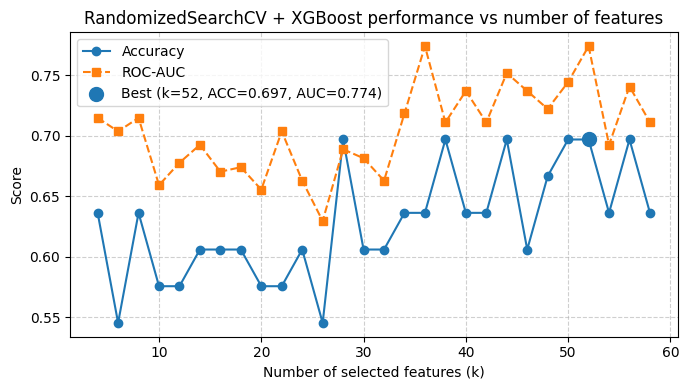

In [64]:
# Descriptors + MACCS
ranking = kbest_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Model LASSO Features Tuning (Randomized Search CV)


=== RandomizedSearchCV: top 4 features ===
  AUC=0.735 | ACC=0.667

=== RandomizedSearchCV: top 6 features ===
  AUC=0.704 | ACC=0.606

=== RandomizedSearchCV: top 8 features ===
  AUC=0.759 | ACC=0.667

=== RandomizedSearchCV: top 10 features ===
  AUC=0.656 | ACC=0.576

=== RandomizedSearchCV: top 12 features ===
  AUC=0.663 | ACC=0.576

=== RandomizedSearchCV: top 14 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 16 features ===
  AUC=0.667 | ACC=0.545

=== RandomizedSearchCV: top 18 features ===
  AUC=0.719 | ACC=0.697

=== RandomizedSearchCV: top 20 features ===
  AUC=0.726 | ACC=0.727

=== RandomizedSearchCV: top 22 features ===
  AUC=0.741 | ACC=0.727

=== RandomizedSearchCV: top 24 features ===
  AUC=0.759 | ACC=0.667

=== RandomizedSearchCV: top 26 features ===
  AUC=0.752 | ACC=0.697

=== RandomizedSearchCV: top 28 features ===
  AUC=0.763 | ACC=0.667

=== RandomizedSearchCV: top 30 features ===
  AUC=0.748 | ACC=0.697

=== RandomizedSearchCV: top 32 featu

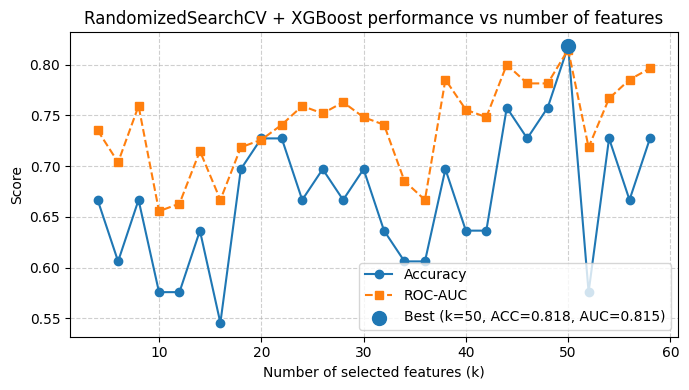

In [65]:
# Descriptors
ranking = lasso_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k descriptor features
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel  = X_test[top_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.696 | ACC=0.697

=== RandomizedSearchCV: top 6 features ===
  AUC=0.674 | ACC=0.606

=== RandomizedSearchCV: top 8 features ===
  AUC=0.707 | ACC=0.636

=== RandomizedSearchCV: top 10 features ===
  AUC=0.659 | ACC=0.606

=== RandomizedSearchCV: top 12 features ===
  AUC=0.648 | ACC=0.636

=== RandomizedSearchCV: top 14 features ===
  AUC=0.652 | ACC=0.606

=== RandomizedSearchCV: top 16 features ===
  AUC=0.715 | ACC=0.667

=== RandomizedSearchCV: top 18 features ===
  AUC=0.663 | ACC=0.545

=== RandomizedSearchCV: top 20 features ===
  AUC=0.693 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.678 | ACC=0.576

=== RandomizedSearchCV: top 24 features ===
  AUC=0.700 | ACC=0.606

=== RandomizedSearchCV: top 26 features ===
  AUC=0.674 | ACC=0.576

=== RandomizedSearchCV: top 28 features ===
  AUC=0.715 | ACC=0.697

=== RandomizedSearchCV: top 30 features ===
  AUC=0.733 | ACC=0.697

=== RandomizedSearchCV: top 32 featu

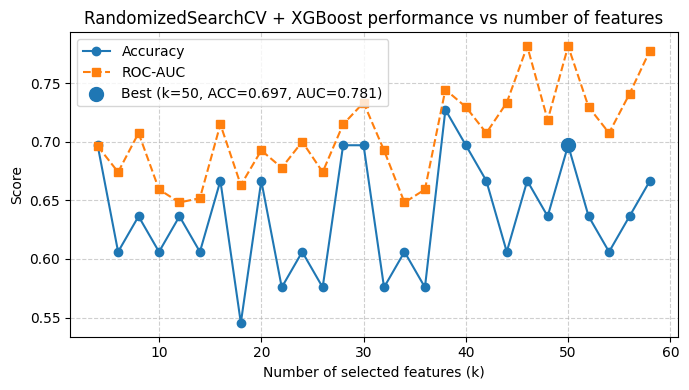

In [66]:
# Descriptors + Morgan
ranking = lasso_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + morgan_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.800 | ACC=0.788

=== RandomizedSearchCV: top 6 features ===
  AUC=0.730 | ACC=0.667

=== RandomizedSearchCV: top 8 features ===
  AUC=0.778 | ACC=0.727

=== RandomizedSearchCV: top 10 features ===
  AUC=0.752 | ACC=0.667

=== RandomizedSearchCV: top 12 features ===
  AUC=0.689 | ACC=0.667

=== RandomizedSearchCV: top 14 features ===
  AUC=0.715 | ACC=0.667

=== RandomizedSearchCV: top 16 features ===
  AUC=0.737 | ACC=0.636

=== RandomizedSearchCV: top 18 features ===
  AUC=0.759 | ACC=0.697

=== RandomizedSearchCV: top 20 features ===
  AUC=0.759 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.781 | ACC=0.727

=== RandomizedSearchCV: top 24 features ===
  AUC=0.778 | ACC=0.636

=== RandomizedSearchCV: top 26 features ===
  AUC=0.833 | ACC=0.667

=== RandomizedSearchCV: top 28 features ===
  AUC=0.730 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.737 | ACC=0.697

=== RandomizedSearchCV: top 32 featu

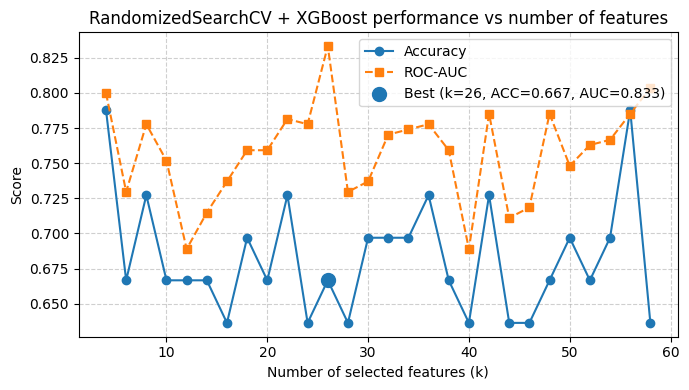

In [67]:
# Descriptors + Atompair
ranking = lasso_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + atompair_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
# Descriptors + RDkit
ranking = lasso_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + rdk_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.696 | ACC=0.667

=== RandomizedSearchCV: top 6 features ===
  AUC=0.715 | ACC=0.636

=== RandomizedSearchCV: top 8 features ===
  AUC=0.715 | ACC=0.697

=== RandomizedSearchCV: top 10 features ===
  AUC=0.648 | ACC=0.667

=== RandomizedSearchCV: top 12 features ===
  AUC=0.763 | ACC=0.727

=== RandomizedSearchCV: top 14 features ===
  AUC=0.704 | ACC=0.636

=== RandomizedSearchCV: top 16 features ===
  AUC=0.748 | ACC=0.667

=== RandomizedSearchCV: top 18 features ===
  AUC=0.693 | ACC=0.636

=== RandomizedSearchCV: top 20 features ===
  AUC=0.733 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.756 | ACC=0.667

=== RandomizedSearchCV: top 24 features ===
  AUC=0.700 | ACC=0.667

=== RandomizedSearchCV: top 26 features ===
  AUC=0.707 | ACC=0.697

=== RandomizedSearchCV: top 28 features ===
  AUC=0.730 | ACC=0.606

=== RandomizedSearchCV: top 30 features ===
  AUC=0.770 | ACC=0.667

=== RandomizedSearchCV: top 32 featu


=== RandomizedSearchCV: top 4 features ===
  AUC=0.759 | ACC=0.727

=== RandomizedSearchCV: top 6 features ===
  AUC=0.800 | ACC=0.727

=== RandomizedSearchCV: top 8 features ===
  AUC=0.759 | ACC=0.788

=== RandomizedSearchCV: top 10 features ===
  AUC=0.796 | ACC=0.697

=== RandomizedSearchCV: top 12 features ===
  AUC=0.656 | ACC=0.606

=== RandomizedSearchCV: top 14 features ===
  AUC=0.737 | ACC=0.727

=== RandomizedSearchCV: top 16 features ===
  AUC=0.800 | ACC=0.727

=== RandomizedSearchCV: top 18 features ===
  AUC=0.759 | ACC=0.697

=== RandomizedSearchCV: top 20 features ===
  AUC=0.781 | ACC=0.727

=== RandomizedSearchCV: top 22 features ===
  AUC=0.759 | ACC=0.697

=== RandomizedSearchCV: top 24 features ===
  AUC=0.741 | ACC=0.667

=== RandomizedSearchCV: top 26 features ===
  AUC=0.770 | ACC=0.667

=== RandomizedSearchCV: top 28 features ===
  AUC=0.689 | ACC=0.636

=== RandomizedSearchCV: top 30 features ===
  AUC=0.737 | ACC=0.636

=== RandomizedSearchCV: top 32 featu

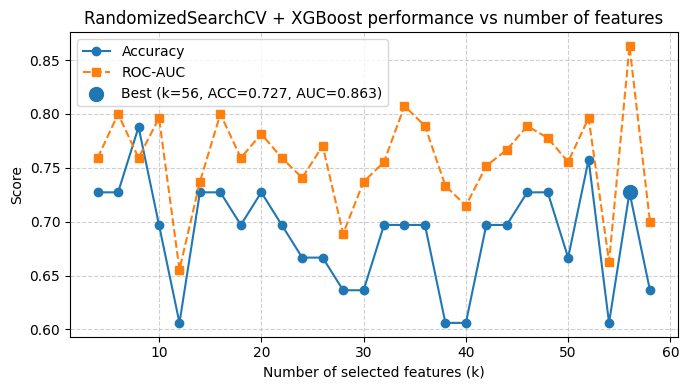

In [69]:
# Descriptors + Torsion
ranking = lasso_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + torsion_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



=== RandomizedSearchCV: top 4 features ===
  AUC=0.785 | ACC=0.727

=== RandomizedSearchCV: top 6 features ===
  AUC=0.685 | ACC=0.667

=== RandomizedSearchCV: top 8 features ===
  AUC=0.744 | ACC=0.636

=== RandomizedSearchCV: top 10 features ===
  AUC=0.730 | ACC=0.697

=== RandomizedSearchCV: top 12 features ===
  AUC=0.733 | ACC=0.667

=== RandomizedSearchCV: top 14 features ===
  AUC=0.748 | ACC=0.667

=== RandomizedSearchCV: top 16 features ===
  AUC=0.748 | ACC=0.697

=== RandomizedSearchCV: top 18 features ===
  AUC=0.696 | ACC=0.697

=== RandomizedSearchCV: top 20 features ===
  AUC=0.741 | ACC=0.667

=== RandomizedSearchCV: top 22 features ===
  AUC=0.733 | ACC=0.606

=== RandomizedSearchCV: top 24 features ===
  AUC=0.700 | ACC=0.697

=== RandomizedSearchCV: top 26 features ===
  AUC=0.796 | ACC=0.727

=== RandomizedSearchCV: top 28 features ===
  AUC=0.781 | ACC=0.727

=== RandomizedSearchCV: top 30 features ===
  AUC=0.737 | ACC=0.697

=== RandomizedSearchCV: top 32 featu

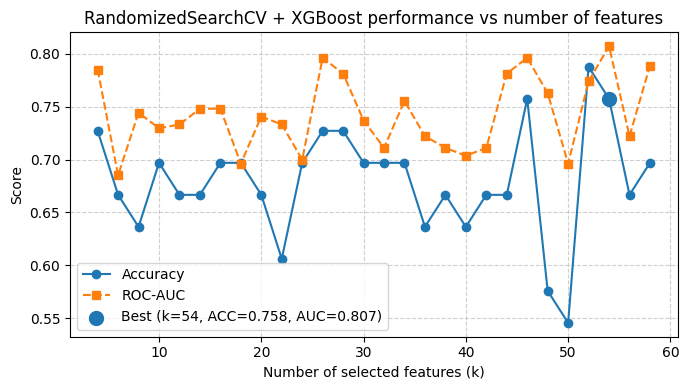

In [70]:
# Descriptors + MACCS
ranking = lasso_features

# Hyperparameter search space
param_dist = {
    "n_estimators": np.arange(20, 120, 10),
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8],
}

rs_results = []

for k in range(4, min(60, len(ranking) + 1), 2):
    print(f"\n=== RandomizedSearchCV: top {k} features ===")

    # Select top-k features + fingerprint
    top_feats = ranking.head(k).index.tolist()

    sel_feats = top_feats + maccs_cols

    X_train_sel = X_train[sel_feats]
    X_test_sel  = X_test[sel_feats]

    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    # Randomized search over param_dist
    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_params = search.best_params_
    best_model = search.best_estimator_

    # Test-set evaluation
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rs_results.append({
        "k": k,
        "accuracy": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "best_params": best_params,
    })

    # Between-k print
    print(f"  AUC={auc:.3f} | ACC={acc:.3f}")

rs_df = pd.DataFrame(rs_results)

# Maximize AUC
max_auc = rs_df["auc"].max()

# Among those with that AUC - maximize Accuracy
tol = 0.01
candidates = rs_df[np.abs(rs_df["auc"] - max_auc) <= tol]
best_row = candidates.loc[candidates["accuracy"].idxmax()]

best_k   = int(best_row["k"])
best_auc = float(best_row["auc"])
best_acc = float(best_row["accuracy"])

print(f"\nBest k by AUC (tie-broken by ACC):")
print(f"  k   = {best_k}")
print(f"  AUC = {best_auc:.3f}")
print(f"  ACC = {best_acc:.3f}")

print("\nBest-k full metrics:")
print(best_row[["accuracy", "auc", "precision", "recall", "f1", "sensitivity", "specificity"]])

print("\nBest-k hyperparameters:")
for param, value in best_row["best_params"].items():
    print(f"  {param}: {value}")

# Diagram
plt.figure(figsize=(7, 4))
plt.plot(rs_df["k"], rs_df["accuracy"], "o-", label="Accuracy")
plt.plot(rs_df["k"], rs_df["auc"], "s--", label="ROC-AUC")

# Highlight best k
plt.scatter([best_k], [best_acc], s=100, zorder=5,
            label=f"Best (k={best_k}, ACC={best_acc:.3f}, AUC={best_auc:.3f})")

plt.title("RandomizedSearchCV + XGBoost performance vs number of features")
plt.xlabel("Number of selected features (k)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
